# DSRM Report 2 January Assignment (65%), Candidate Number: 244794

## Section 1: Introduction and Background

The purpose of this project is to develop an activity recognition system capable of classifying the type and amount of physical activity occurring. Human Activity recognition is a difficult problem as there are no universal standards; activity shows great variance from one participant to the next. Modelling can often help alleviate this issue.

This project utilises the PAMAP2 Physical Activity Monitoring Dataset [1] which contains 18 different physical activities of varying intensity from 9 different participants. This dataset contained a folder named 'Protocol' which consisted of 12 core activities and an 'Optional' folder which contained 6 additional activities.

The information relating to the activity type was generated from a number of sensors:
- Three inertial measurement units (IMUs) at 100Hz sampling frequency:Wrist,Chest,Dominant ankle
- Heart rate monitor at 9Hz sampling frequency

There were also additional files and data beyond the initial dataset [1]:
- DataCollectionProtocol.pdf: Protocol activities and the length of time in which activities were performed.
- DescriptionOfActivities.pdf: A detailed list of what each activity entailed.
- PerformedActivitiesSummary.pdf: A table of cumulative activity totals
- readme.pdf: A summary of protocol and issues related to the collection of the data
- subjectInformation.pdf: A table of subject attributes and characteristics.

Throughout this project, all aspects of the data will be utilised to formulate actionable insights related to the proposed activity recognition system.

## Section 2: Exploratory Data Analysis and Setup

### 2.1 Downloads and Imports

In [604]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import random
from statistics import mean, stdev
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_score

### 2.2 Loading the Data

The data was located in two folders. Within each of these folders, there were subfolders containing the data for each participant. When loading in the dataset for the first participant, it was noted that there were no columns attached to the data.

In [504]:
filepath = 'PAMAP2_Dataset/PAMAP2_Dataset/Protocol/subject101.dat' #only exploring subject1 at the moment
test_eda = pd.read_csv(filepath,sep=' ')
test_eda.head()

,8.38,0,104,30,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.00830026,0.00925038,-0.0175803,-61.1888,-38.9599,-58.1438,1.2,0.7,0.8,0.9
0,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
1,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0
2,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0
3,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0
4,8.43,0,NaN,30.0,2.29959,8.82929,3.54710,2.26132,8.65762,3.77788,...,-0.006089,-0.016024,0.001050,-60.2954,-38.8778,-58.3977,1.0,0.0,0.0,0.0


The columns were described in 'readme.pdf' as a series of 54 columns and the activityIDs were also listed which are shown in the cells below.

In [505]:
#setup for later
activities = {1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking', 5: 'running', 6: 'cycling', 7: 'nordic walking', 9: 'watching TV',\
              10: 'computer work', 11: 'car driving',12: 'ascending stairs',13: 'descending stairs',16: 'vacuum cleaning', \
              17: 'ironing',18: 'folding laundry',19: 'house cleaning', 20: 'playing soccer',24: 'jump roping', \
              0: 'other (transient activity)'}

In [506]:
#columns according to readme file
IMU_hand = ['Temperature_H (C)', '3DaccH1_16', '3DaccH2_16', '3DaccH3_16', '3DaccH1_6', '3DaccH2_6',
            '3DaccH3_6', '3Dgyro_H1', '3Dgyro_H2', '3Dgyro_H3', '3Dmag_H1', '3Dmag_H2', '3Dmag_H3',
            'HO1', 'HO2', 'HO3', 'HO4'] #hand columns

IMU_chest =  ['Temperature_C (C)', '3DaccC1_16', '3DaccC2_16', '3DaccC3_16', '3DaccC1_6', '3DaccC2_6',
            '3DaccC3_6', '3Dgyro_C1', '3Dgyro_C2', '3Dgyro_C3', '3Dmag_C1', '3Dmag_C2', '3Dmag_C3',
            'CO1', 'CO2', 'CO3', 'CO4'] #chest columns

IMU_ankle =  ['Temperature_A (C)', '3DaccA1_16', '3DaccA2_16', '3DaccA3_16', '3DaccA1_6', '3DaccA2_6',
            '3DaccA3_6', '3Dgyro_A1', '3Dgyro_A2', '3Dgyro_A3', '3Dmag_A1', '3Dmag_A2', '3Dmag_A3',
            'AO1', 'AO2', 'AO3', 'AO4'] #ankle columns

cols = ['Timestamp (s)', 'ActivityID', 'Heart Rate (bpm)'] + IMU_hand + IMU_chest + IMU_ankle #additional columns

As all participant data was located in separate subfolders, these individual datasets must be joined for both the 'Protocol' and 'Optional' folders, and an extra column named 'participant' needs to be integrated into the complete dataset.

In [507]:
filepath = 'PAMAP2_Dataset/PAMAP2_Dataset/Protocol/' #make sure the file is in your working directory
subject_list = os.listdir(filepath) #lists all folders in the filepath

#attaching participant number to df
data = pd.DataFrame() #empty df to append to
for i,subject in enumerate(subject_list):
    df = pd.read_csv(filepath + subject, header = None, sep=' ')
    df.columns = cols #assign cols stated earlier as new df columns
    df['participant'] = i + 1 #+1 because starting from subject 1, not 0
    data = pd.concat([data,df])
    
data

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3DaccH1_6,3DaccH2_6,3DaccH3_6,...,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,AO1,AO2,AO3,AO4,participant
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.95990,-58.143800,1.000000,0.000000,0.000000,0.000000,1
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.89190,-58.525300,1.000000,0.000000,0.000000,0.000000,1
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.41380,-58.399900,1.000000,0.000000,0.000000,0.000000,1
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.76350,-58.395600,1.000000,0.000000,0.000000,0.000000,1
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.38790,-58.269400,1.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8472,100.19,0,NaN,25.1875,-4.71493,10.22250,4.66893,-5.04654,9.94944,4.50736,...,-0.062676,-0.127084,-46.5153,3.58240,-0.035995,0.598531,0.033615,0.799791,-0.031075,9
8473,100.20,0,NaN,25.1875,-4.95932,10.37130,4.12594,-4.96890,10.29620,4.43102,...,-0.027006,-0.089808,-45.7474,3.54453,0.108583,0.598428,0.033012,0.799933,-0.030018,9
8474,100.21,0,NaN,25.1875,-4.93997,9.83615,3.70468,-5.04613,10.35690,4.14405,...,-0.038024,-0.064709,-46.3997,4.22078,0.105504,0.598233,0.033172,0.800095,-0.029416,9
8475,100.22,0,NaN,25.1875,-4.64941,9.11129,3.51904,-5.06854,9.75268,3.87359,...,-0.025796,-0.064357,-46.5282,4.48593,0.530240,0.598116,0.033427,0.800180,-0.029208,9


In [508]:
filepath2 = 'PAMAP2_Dataset/PAMAP2_Dataset/Optional/'
opt_subject_list = os.listdir(filepath2)

data_opt = pd.DataFrame()

for subject in (opt_subject_list):
    df_opt = pd.read_csv(filepath2  + subject,header = None, sep = ' ')
    df_opt.columns = cols
    indexer = subject[9] #have to do like this because subjects are not consecutive, 8th char represents subject number
    df_opt['participant'] = int(indexer) 
    #do not change from int otherwise subject X from df1 and subject X from df2 will not be the same person
    data_opt = pd.concat([data_opt,df_opt])

data_opt

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3DaccH1_6,3DaccH2_6,3DaccH3_6,...,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,AO1,AO2,AO3,AO4,participant
0,10.03,0,105.0,33.3125,1.99964,6.94837,5.08845,2.62244,7.73457,4.64028,...,0.009471,0.003633,-43.8463,-2.97306,45.0822,1.000000,0.000000,0.000000,0.000000,1
1,10.04,0,NaN,33.3125,1.80990,6.45729,5.16424,2.19725,6.93762,5.06528,...,0.070031,0.001804,-43.8385,-2.55481,46.8195,1.000000,0.000000,0.000000,0.000000,1
2,10.05,0,NaN,33.3125,1.82756,5.93151,5.78208,2.01408,6.28989,5.44441,...,-0.002170,0.012096,-43.6100,-3.00084,46.5653,1.000000,0.000000,0.000000,0.000000,1
3,10.06,0,NaN,33.3125,1.75760,5.78202,5.97397,1.83344,5.83858,5.92881,...,-0.008545,0.007356,-43.5199,-1.99822,45.5850,1.000000,0.000000,0.000000,0.000000,1
4,10.07,0,NaN,33.3125,1.50670,6.20407,6.27669,1.71564,5.82465,6.27627,...,0.036445,-0.004679,-43.6258,-2.43575,45.5812,1.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193467,1940.78,0,NaN,24.8750,-6.51915,6.87682,2.34395,-6.67159,6.87843,2.50735,...,0.028883,-0.016737,-40.1550,-18.41770,25.3998,0.276396,-0.692785,0.412759,-0.522766,9
193468,1940.79,0,NaN,24.8750,-6.47548,6.95375,2.49829,-6.71706,6.87873,2.47720,...,0.040632,-0.015746,-39.7605,-18.82270,25.6854,0.276461,-0.692737,0.412749,-0.522804,9
193469,1940.80,0,NaN,24.8750,-6.58698,6.84148,2.57398,-6.79405,6.81875,2.34150,...,0.068296,0.001916,-39.3718,-19.09960,25.6871,0.276468,-0.692669,0.412555,-0.523042,9
193470,1940.81,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.011902,0.006604,-39.5070,-18.96540,25.2609,0.276608,-0.692688,0.412525,-0.522966,9


In [509]:
full_data = pd.concat([data,data_opt])
test_section2 = full_data
full_data

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3DaccH1_6,3DaccH2_6,3DaccH3_6,...,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,AO1,AO2,AO3,AO4,participant
0,8.38,0,104.0,30.000,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.000000,0.000000,0.000000,0.000000,1
1,8.39,0,NaN,30.000,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.000000,0.000000,0.000000,0.000000,1
2,8.40,0,NaN,30.000,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.000000,0.000000,0.000000,0.000000,1
3,8.41,0,NaN,30.000,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.000000,0.000000,0.000000,0.000000,1
4,8.42,0,NaN,30.000,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193467,1940.78,0,NaN,24.875,-6.51915,6.87682,2.34395,-6.67159,6.87843,2.50735,...,0.028883,-0.016737,-40.1550,-18.4177,25.3998,0.276396,-0.692785,0.412759,-0.522766,9
193468,1940.79,0,NaN,24.875,-6.47548,6.95375,2.49829,-6.71706,6.87873,2.47720,...,0.040632,-0.015746,-39.7605,-18.8227,25.6854,0.276461,-0.692737,0.412749,-0.522804,9
193469,1940.80,0,NaN,24.875,-6.58698,6.84148,2.57398,-6.79405,6.81875,2.34150,...,0.068296,0.001916,-39.3718,-19.0996,25.6871,0.276468,-0.692669,0.412555,-0.523042,9
193470,1940.81,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.011902,0.006604,-39.5070,-18.9654,25.2609,0.276608,-0.692688,0.412525,-0.522966,9


The subjectInformation.pdf also contained useful data, so this can be used to create another dataframe for our analysis. As only 'dominant ankle' was specified as a location of the ankle sensor, rather than 'dominant hand' for the hand sensor, the relevance of the 'dominant hand' label in this data seemed insignificant. It could be the case that the hand IMU sensors were placed on the dominant hand, or that the dominant ankle is the same as the dominant hand, but as this was not specified it will be eliminated.

In [510]:
#manual creation of subject dataset, was going to use tabula library but there were issues java path location 

s_cols = ['Subject ID', 'Sex','Age','Height (cm)','Weight (kg)','Resting HR (bpm)','Max HR (bpm)']
subject_data = {'Subject ID': [1,2,3,4,5,6,7,8,9],
               'Sex': ['Male','Female', 'Male','Male','Male','Male','Male','Male','Male'],
               'Age':[27,25,31,24,26,26,23,32,31],
               'Height (cm)': [182,169,187,194,180,183,173,179,168],
               'Weight (kg)': [83,78,92,95,73,69,86,87,65],
               'Resting HR (bpm)':[75,74,68,58,70,60,60,66,54],
               'Max HR (bpm)':[193,195,189,196,194,194,197,188,189],
               }

subject_df = pd.DataFrame(subject_data)
subject_df

,Subject ID,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm)
0,1,Male,27,182,83,75,193
1,2,Female,25,169,78,74,195
2,3,Male,31,187,92,68,189
3,4,Male,24,194,95,58,196
4,5,Male,26,180,73,70,194
5,6,Male,26,183,69,60,194
6,7,Male,23,173,86,60,197
7,8,Male,32,179,87,66,188
8,9,Male,31,168,65,54,189


### 2.3 Data Cleaning

The readme.pdf file stated a number of existing issues with the data collection, and a number of issues can also evidentally be observed as seen in the dataframe 'full_data'. These ideally need to be resolved before any valid analysis can take place.

The issues already stated with the dataset are:
- Many NaN values due to wireless signal drop
- Issues with the +/-6g acceleration scale being too inaccurate
- Orientation columns being invalid due to +/- 6g inaccuracies.
- Lots of transient activity denoted as activity ID 0

The creators of the dataset suggest to delete this data, which is also why NaN's with no explanation have been completely deleted as seen below. 

From our own observations it is evident that there is lots of missing data for heart rate, but this is explained by the frequency sampling difference of the IMU and heart rate sensors: e.g. 100Hz v 9Hz. So essentially for every 0.01s of data, we only observe a heart rate entry every 0.111s.

It was also noted that the activity ID values do not exactly follow a consecutive order, e.g. there were no activity IDs 8,14,15 and so on. These IDs may be reserved for 'breaks' as shown in the 'DataCollectionProtocol' file, however they should not appear in the final dataset, so this will be checked. As a 'PerformedActivitiesSummary' has been provided, this should be corroborated to the dataset to ensure no participant is noted as doing an activity that they did not actually do, nor are they missing activities that they did perform.

In [511]:
#checking that there are no mislabelled activities outside of the definitions
check_id = full_data.loc[full_data['ActivityID'] > 24] #also iterated through  == 8,14,15,21,22,23 etc
check_id #it was fine for all

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3DaccH1_6,3DaccH2_6,3DaccH3_6,...,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,AO1,AO2,AO3,AO4,participant


In [512]:
#just a cell to explore potential errors
checkparticipant = full_data.loc[full_data['participant'] == 4] #iterate through subject and id as neccessary
checkparticipant = checkparticipant.loc[checkparticipant['ActivityID'] == 5] 
checkparticipant

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3DaccH1_6,3DaccH2_6,3DaccH3_6,...,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,AO1,AO2,AO3,AO4,participant
329575,3301.46,5,NaN,27.5,-4.61858,6.44599,-5.9394,-4.5911,6.38731,-5.98033,...,-0.000262,-0.00119,-49.8489,5.81694,2.78633,0.541308,0.325367,0.708377,0.315156,4


The cell above was used as an exploratory task. It also appeared that for activity ID 12 and 13 there was always an extra entry or two. A few more duplicates were found here but this is likely due to the small sampling differences between IMU sensors. As shown above for subject 4, there was an entry in activityID5 when there should have been none.

In [513]:
#if everything is accounted for according to the summary pdf, should be no errors
ch_1 = full_data[((full_data.participant == 1) & (full_data.ActivityID.isin([10,20])))]
ch_2 = full_data[((full_data.participant == 2) & (full_data.ActivityID.isin([9,10,11,18,19,20])))]
ch_3 = full_data[((full_data.participant == 3) & (full_data.ActivityID.isin([5,6,7,9,10,11,18,19,20,24])))]
ch_4 = full_data[((full_data.participant == 4) & (full_data.ActivityID.isin([5,9,10,11,18,19,20,24])))]
ch_5 = full_data[((full_data.participant == 5) & (full_data.ActivityID.isin([9,11,18,20])))]
ch_6 = full_data[((full_data.participant == 6) & (full_data.ActivityID.isin([9,11,20])))] 
ch_7 = full_data[((full_data.participant == 7) & (full_data.ActivityID.isin([9,10,11,18,19,20,24])))] 
ch_8 = full_data[((full_data.participant == 8) & (full_data.ActivityID.isin([9,11])))] 
ch_9 = full_data[((full_data.participant == 9) & (full_data.ActivityID.isin([1,2,3,4,5,6,7,9,11,12,13,16,17])))]

to_drop = [ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,ch_8]

In [514]:
totl = 0
for i in range(len(to_drop)):
    totl += len(to_drop[i])

print('There are',totl, 'rows with errors')

There are 1 rows with errors


In [515]:
full_data = full_data[full_data['ActivityID'] != 0] #getting rid of transient activity

todrop = ['3DaccH1_6', '3DaccH2_6','3DaccH3_6', 'HO1', 'HO2', 'HO3', 'HO4',
         '3DaccC1_6', '3DaccC2_6','3DaccC3_6', 'CO1', 'CO2', 'CO3', 'CO4',
         '3DaccA1_6', '3DaccA2_6','3DaccA3_6','AO1', 'AO2', 'AO3', 'AO4'] #columns with issues stated in documentation

clean_column_data = full_data.drop(todrop, axis = 1) #rename to avoid re-run errors
clean_column_data = clean_column_data.reset_index(drop =True) #recounts index

#dropping incorrect entries
for i in range(len(to_drop)):
    ind = to_drop[i].index
    error_cleaned = clean_column_data.drop(ind)

In [516]:
error_cleaned

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3DaccA1_16,3DaccA2_16,3DaccA3_16,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant
0,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1
1,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,9.69762,-1.884380,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1
2,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1
3,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,9.66370,-1.847140,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724948,1936.14,20,NaN,24.875,-6.42779,6.84232,2.80728,-0.021124,0.107389,0.043537,...,9.26409,-0.561116,-3.660880,-0.013752,0.011737,-0.011313,-39.3605,-19.4856,25.9712,9
2724949,1936.15,20,NaN,24.875,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,...,9.30900,-0.183274,-3.469820,-0.009593,-0.014075,-0.052507,-38.7226,-19.7765,25.4065,9
2724950,1936.16,20,NaN,24.875,-6.41763,6.57977,3.15471,-0.014853,0.079020,0.041868,...,9.30959,-0.069368,-3.470520,-0.010825,-0.025462,-0.057343,-39.3523,-19.8722,25.9717,9
2724951,1936.17,20,NaN,24.875,-6.46049,6.42730,3.03912,0.012556,0.068029,0.050227,...,9.23414,-0.182800,-3.470590,-0.019402,-0.002942,-0.033522,-38.7082,-20.1618,25.9743,9


In order to solve the issue with the heart rate sensor sampling frequency, the missing values were simply filled with the last valid value. Interpolation could have also been used here, but it seemed to be inappropriate as it is very unlikely that heart rate values will see drastic changes within 0.111 seconds.

In [517]:
nan_clean = error_cleaned['Heart Rate (bpm)'] 
nan_clean = nan_clean.fillna(method = 'bfill').fillna(method = 'ffill') 
#need both ffill and bfill as we will miss the first and last set of entries otherwise,
#generally tries to backfill first though

In [518]:
error_cleaned['Heart Rate (bpm)'] = nan_clean
error_cleaned

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3DaccA1_16,3DaccA2_16,3DaccA3_16,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant
0,37.66,1,100.0,30.375,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,...,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1
1,37.67,1,100.0,30.375,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,...,9.69762,-1.884380,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1
2,37.68,1,100.0,30.375,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,...,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1
3,37.69,1,100.0,30.375,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,...,9.66370,-1.847140,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,...,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724948,1936.14,20,178.0,24.875,-6.42779,6.84232,2.80728,-0.021124,0.107389,0.043537,...,9.26409,-0.561116,-3.660880,-0.013752,0.011737,-0.011313,-39.3605,-19.4856,25.9712,9
2724949,1936.15,20,178.0,24.875,-6.39107,6.69028,2.80834,0.020008,0.105153,0.027290,...,9.30900,-0.183274,-3.469820,-0.009593,-0.014075,-0.052507,-38.7226,-19.7765,25.4065,9
2724950,1936.16,20,178.0,24.875,-6.41763,6.57977,3.15471,-0.014853,0.079020,0.041868,...,9.30959,-0.069368,-3.470520,-0.010825,-0.025462,-0.057343,-39.3523,-19.8722,25.9717,9
2724951,1936.17,20,178.0,24.875,-6.46049,6.42730,3.03912,0.012556,0.068029,0.050227,...,9.23414,-0.182800,-3.470590,-0.019402,-0.002942,-0.033522,-38.7082,-20.1618,25.9743,9


The other NaN values don't appear to have a valid reason beyond sensor error, so they will be removed as there is actually a lot of variation between one row to the next within the other dataset columns, meaning interpolation of ffill/bfill would be inappropriate.  The code below shows that there are only 23,943 rows of data with remaining missing data which is fairly insignificant to the 2 million + other rows of data we have; it is unlikely to affect any insights we make.

In [519]:
cols_nan = []

for i in error_cleaned.columns:
    tot = error_cleaned[i].isnull().sum() #get the total sum of null entries for a given column
    cols_nan.append(tot)

In [520]:
nan_df = pd.DataFrame(data = cols_nan, index = error_cleaned.columns, columns = None)
nan_df.transpose()

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3DaccA1_16,3DaccA2_16,3DaccA3_16,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant
0,0,0,0,11868,11868,11868,11868,11868,11868,11868,...,9867,9867,9867,9867,9867,9867,9867,9867,9867,0


In [521]:
error_cleaned[error_cleaned.isna().any(axis=1)]

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3DaccA1_16,3DaccA2_16,3DaccA3_16,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant
11455,152.21,1,86.0,31.2500,0.554277,9.75846,-0.138475,0.165746,-0.274904,0.041157,...,0.864811,-4.366630,-10.12930,0.254512,-0.113692,-0.120491,-28.2468,35.5646,17.3917,1
11456,152.22,1,86.0,31.2500,1.009900,9.49039,-0.015284,0.250686,-0.362705,0.017707,...,0.784372,-4.592680,-10.28300,0.427240,-0.091716,-0.145038,-29.3660,35.8165,18.0224,1
11585,153.51,1,86.0,31.2500,7.697710,6.77767,-0.483265,0.987565,-0.174650,1.407120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
11589,153.55,1,86.0,31.2500,6.374040,5.31060,-0.228732,1.124680,-0.315897,1.353380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
15975,197.41,1,79.0,31.4375,4.342900,-4.49239,-7.769610,0.221033,0.083176,0.011659,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2724799,1934.65,20,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.353530,-0.299665,-3.19851,0.015612,0.030957,-0.085891,-39.2636,-18.8513,24.4107,9
2724800,1934.66,20,179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.428270,-0.109975,-3.23751,0.025096,0.031765,-0.056712,-40.0183,-19.0695,24.9756,9
2724900,1935.66,20,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.423280,-0.222596,-3.39122,0.012650,0.006531,0.042274,-39.6047,-19.8588,26.2544,9
2724925,1935.91,20,178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.462820,-0.451608,-3.27363,-0.034790,0.047308,-0.022063,-38.4835,-19.0160,25.4064,9


In [522]:
nan_cleaned = error_cleaned.dropna()
cleaned = nan_cleaned

In [523]:
cleaned.loc[cleaned.iloc[:,3:].duplicated(), :] #(didn't include activity or heart rate or timestamp)

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3DaccA1_16,3DaccA2_16,3DaccA3_16,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant


When observing the location of missing data, a lot of it was observed for participant 9. This jeopardises the validity of the data for subject 9. In later exploratory tasks, (although not shown) it was found that subject 9 significantly skews all relationships between features. For instance, they had very low heart rates for vigorous activity where all other participants had the opposite. It therefore seemed appropriate to eliminate participant 9 from all analysis as the data was not reliable. As we cannot determine why the data is poor, it is best to just remove it.

In [524]:
p9_drop = cleaned[((cleaned.participant == 9))]
p9idx = p9_drop.index
cleaned = cleaned.drop(p9idx, axis = 0)
cleaned

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3DaccA1_16,3DaccA2_16,3DaccA3_16,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant
0,37.66,1,100.0,30.375,2.21530,8.27915,5.587530,-0.004750,0.037579,-0.011145,...,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.36960,1
1,37.67,1,100.0,30.375,2.29196,7.67288,5.744670,-0.171710,0.025479,-0.009538,...,9.69762,-1.884380,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.36560,1
2,37.68,1,100.0,30.375,2.29090,7.14240,5.823420,-0.238241,0.011214,0.000831,...,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.61190,1
3,37.69,1,100.0,30.375,2.21800,7.14365,5.899300,-0.192912,0.019053,0.013374,...,9.66370,-1.847140,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.87990,1
4,37.70,1,100.0,30.375,2.30106,7.25857,6.092590,-0.069961,-0.018328,0.004582,...,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.88470,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566075,1802.34,20,76.0,30.750,-9.67904,-2.48860,0.288379,0.054178,0.005046,0.014478,...,9.26796,-0.029877,-3.625550,0.123540,-0.039243,0.010627,-44.4522,-10.7843,9.06518,8
2566076,1802.35,20,76.0,30.750,-9.75008,-2.41113,0.402515,0.003091,-0.041373,0.061613,...,9.34380,0.159491,-3.625950,0.144035,-0.010783,0.005433,-44.9631,-10.7589,9.06336,8
2566077,1802.36,20,76.0,30.750,-9.77985,-2.40883,0.632986,0.002789,-0.015547,0.058264,...,9.34230,0.083875,-3.664080,0.093930,-0.006472,0.012432,-44.3439,-10.0181,8.78101,8
2566078,1802.37,20,76.0,30.750,-9.71149,-2.48696,0.441837,0.011045,-0.007121,0.055302,...,9.41925,0.272923,-3.625880,0.096512,-0.003575,-0.010379,-44.5932,-10.5219,8.35522,8


With our entire dataset cleaned, we can now describe our complete dataset as seen below. The final dataset contained 2,536,459 entries and 8 participants. Without considering the timestamp, ActivityID and participant number, there are 31 features to consider for analysis.

In [525]:
cleaned.describe()

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3DaccA1_16,3DaccA2_16,3DaccA3_16,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant
count,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,...,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06,2.536460e+06
mean,1.558164e+03,9.346507e+00,1.032987e+02,3.293809e+01,-3.862812e+00,3.573364e+00,3.896446e+00,6.255920e-04,3.768388e-02,-5.844984e-03,...,8.992584e+00,-4.472182e-01,-2.763539e+00,6.738661e-03,-2.515453e-02,1.545997e-03,-2.945503e+01,1.804933e+00,1.722354e+01,4.540774e+00
std,1.049675e+03,6.177723e+00,2.620258e+01,1.721296e+00,6.265896e+00,6.582521e+00,4.108740e+00,1.277700e+00,9.285109e-01,1.455002e+00,...,6.012985e+00,6.979528e+00,3.673994e+00,1.019424e+00,5.702234e-01,1.756586e+00,1.976808e+01,2.216362e+01,2.056047e+01,2.444160e+00
min,3.766000e+01,1.000000e+00,5.700000e+01,2.750000e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-2.780440e+01,-1.339040e+01,-1.426470e+01,...,-1.536740e+02,-1.574430e+02,-1.589260e+02,-2.907750e+01,-1.812690e+01,-1.647420e+01,-1.728650e+02,-1.404600e+02,-1.523230e+02,1.000000e+00
25%,6.627900e+02,4.000000e+00,8.300000e+01,3.187500e+01,-8.447950e+00,9.322945e-01,1.316680e+00,-3.027698e-01,-1.630530e-01,-2.552837e-01,...,8.279730e+00,-2.473830e+00,-3.889470e+00,-9.915607e-02,-6.082755e-02,-1.516637e-01,-4.094240e+01,-1.298672e+01,3.342690e+00,2.000000e+00
50%,1.322895e+03,9.000000e+00,9.800000e+01,3.331250e+01,-3.677230e+00,3.665570e+00,3.823355e+00,-5.634900e-03,4.850715e-03,-5.469560e-03,...,9.491240e+00,-3.466820e-01,-2.461720e+00,5.696475e-03,-3.716300e-03,1.012600e-04,-3.093430e+01,4.091040e-01,1.872020e+01,5.000000e+00
75%,2.431450e+03,1.600000e+01,1.200000e+02,3.425000e+01,2.974070e-01,6.920933e+00,6.893480e+00,2.657290e-01,2.041770e-01,2.486383e-01,...,9.871170e+00,1.441005e+00,-1.213237e+00,7.424707e-02,6.477278e-02,5.154995e-02,-1.497978e+01,1.774383e+01,3.353720e+01,7.000000e+00
max,4.245680e+03,2.400000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.411000e+02,2.641580e+01,1.691710e+01,1.433840e+01,...,1.572320e+02,1.561900e+02,1.603430e+02,2.447930e+01,1.358820e+01,1.705130e+01,9.155160e+01,9.424780e+01,1.469000e+02,8.000000e+00


In [526]:
cleaned = cleaned.replace({'ActivityID': activities}) #mapping dictionary of activities to ID
cleaned.reset_index(drop=True) # just in case, cant see all the indexes unsure if its different

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3DaccA1_16,3DaccA2_16,3DaccA3_16,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant
0,37.66,lying,100.0,30.375,2.21530,8.27915,5.587530,-0.004750,0.037579,-0.011145,...,9.73855,-1.847610,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.36960,1
1,37.67,lying,100.0,30.375,2.29196,7.67288,5.744670,-0.171710,0.025479,-0.009538,...,9.69762,-1.884380,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.36560,1
2,37.68,lying,100.0,30.375,2.29090,7.14240,5.823420,-0.238241,0.011214,0.000831,...,9.69633,-1.922030,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.61190,1
3,37.69,lying,100.0,30.375,2.21800,7.14365,5.899300,-0.192912,0.019053,0.013374,...,9.66370,-1.847140,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.87990,1
4,37.70,lying,100.0,30.375,2.30106,7.25857,6.092590,-0.069961,-0.018328,0.004582,...,9.77578,-1.885820,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.88470,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2536455,1802.34,playing soccer,76.0,30.750,-9.67904,-2.48860,0.288379,0.054178,0.005046,0.014478,...,9.26796,-0.029877,-3.625550,0.123540,-0.039243,0.010627,-44.4522,-10.7843,9.06518,8
2536456,1802.35,playing soccer,76.0,30.750,-9.75008,-2.41113,0.402515,0.003091,-0.041373,0.061613,...,9.34380,0.159491,-3.625950,0.144035,-0.010783,0.005433,-44.9631,-10.7589,9.06336,8
2536457,1802.36,playing soccer,76.0,30.750,-9.77985,-2.40883,0.632986,0.002789,-0.015547,0.058264,...,9.34230,0.083875,-3.664080,0.093930,-0.006472,0.012432,-44.3439,-10.0181,8.78101,8
2536458,1802.37,playing soccer,76.0,30.750,-9.71149,-2.48696,0.441837,0.011045,-0.007121,0.055302,...,9.41925,0.272923,-3.625880,0.096512,-0.003575,-0.010379,-44.5932,-10.5219,8.35522,8


It was assumed that for acceleration, the three IMU sensors at each location represented the three cartesian x,y,z axes. It was therefore valuable to translate this data into a resultant acceleration column for each location. This could have been useful for other columns such as gyrometer and magnetometer, however I was unsure what the resultant value would have suggested.

In [527]:
cleaned['Hand Acceleration'] = np.sqrt((cleaned['3DaccH1_16'])**2+(cleaned['3DaccH2_16'])**2+(cleaned['3DaccH3_16'])**2)
cleaned['Ankle Acceleration']= np.sqrt((cleaned['3DaccA1_16'])**2+(cleaned['3DaccA2_16'])**2+(cleaned['3DaccA3_16'])**2)
cleaned['Chest Acceleration'] = np.sqrt((cleaned['3DaccC1_16'])**2+(cleaned['3DaccC2_16'])**2+(cleaned['3DaccC3_16'])**2)

cleaned

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant,Hand Acceleration,Ankle Acceleration,Chest Acceleration
0,37.66,lying,100.0,30.375,2.21530,8.27915,5.587530,-0.004750,0.037579,-0.011145,...,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.36960,1,10.230952,9.912723,9.791172
1,37.67,lying,100.0,30.375,2.29196,7.67288,5.744670,-0.171710,0.025479,-0.009538,...,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.36560,1,9.855324,9.879026,9.791979
2,37.68,lying,100.0,30.375,2.29090,7.14240,5.823420,-0.238241,0.011214,0.000831,...,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.61190,1,9.496016,9.885166,9.907409
3,37.69,lying,100.0,30.375,2.21800,7.14365,5.899300,-0.192912,0.019053,0.013374,...,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.87990,1,9.526437,9.839102,9.879549
4,37.70,lying,100.0,30.375,2.30106,7.25857,6.092590,-0.069961,-0.018328,0.004582,...,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.88470,1,9.751993,9.956473,9.875840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566075,1802.34,playing soccer,76.0,30.750,-9.67904,-2.48860,0.288379,0.054178,0.005046,0.014478,...,0.123540,-0.039243,0.010627,-44.4522,-10.7843,9.06518,8,9.998005,9.951914,10.052302
2566076,1802.35,playing soccer,76.0,30.750,-9.75008,-2.41113,0.402515,0.003091,-0.041373,0.061613,...,0.144035,-0.010783,0.005433,-44.9631,-10.7589,9.06336,8,10.051847,10.023949,10.156766
2566077,1802.36,playing soccer,76.0,30.750,-9.77985,-2.40883,0.632986,0.002789,-0.015547,0.058264,...,0.093930,-0.006472,0.012432,-44.3439,-10.0181,8.78101,8,10.092007,10.035491,10.130272
2566078,1802.37,playing soccer,76.0,30.750,-9.71149,-2.48696,0.441837,0.011045,-0.007121,0.055302,...,0.096512,-0.003575,-0.010379,-44.5932,-10.5219,8.35522,8,10.034602,10.096720,10.013410


### 2.4 EDA 1: Data Distribution of Subjects

Activity can often vary from one participant to the next, so it will be useful to investigate the differences between participants which may cause some of the variance seen in the dataset. Given that we had both height and weight, it seemed intuitive to combine the two characteristics into one single BMI measure.

In [528]:
#deriving BMI
subject_df['BMI'] = subject_df['Weight (kg)']/((subject_df['Height (cm)']/100)**2)
subject_df = subject_df[:8] # we eliminated participant 9 so do not count
subject_df

,Subject ID,Sex,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),BMI
0,1,Male,27,182,83,75,193,25.057360
1,2,Female,25,169,78,74,195,27.309968
2,3,Male,31,187,92,68,189,26.309017
3,4,Male,24,194,95,58,196,25.241790
4,5,Male,26,180,73,70,194,22.530864
5,6,Male,26,183,69,60,194,20.603780
6,7,Male,23,173,86,60,197,28.734672
7,8,Male,32,179,87,66,188,27.152711


In [529]:
subject_df.describe()

,Subject ID,Age,Height (cm),Weight (kg),Resting HR (bpm),Max HR (bpm),BMI
count,8.00000,8.00000,8.000000,8.000000,8.000000,8.00000,8.000000
mean,4.50000,26.75000,180.875000,82.875000,66.375000,193.25000,25.367520
std,2.44949,3.19598,7.772433,9.030702,6.545173,3.19598,2.673574
min,1.00000,23.00000,169.000000,69.000000,58.000000,188.00000,20.603780
25%,2.75000,24.75000,177.500000,76.750000,60.000000,192.00000,24.425736
50%,4.50000,26.00000,181.000000,84.500000,67.000000,194.00000,25.775403
75%,6.25000,28.00000,184.000000,88.250000,71.000000,195.25000,27.192025
max,8.00000,32.00000,194.000000,95.000000,75.000000,197.00000,28.734672


Text(0.5, 1.0, 'Figure 1: Box Plot of Subject Data')

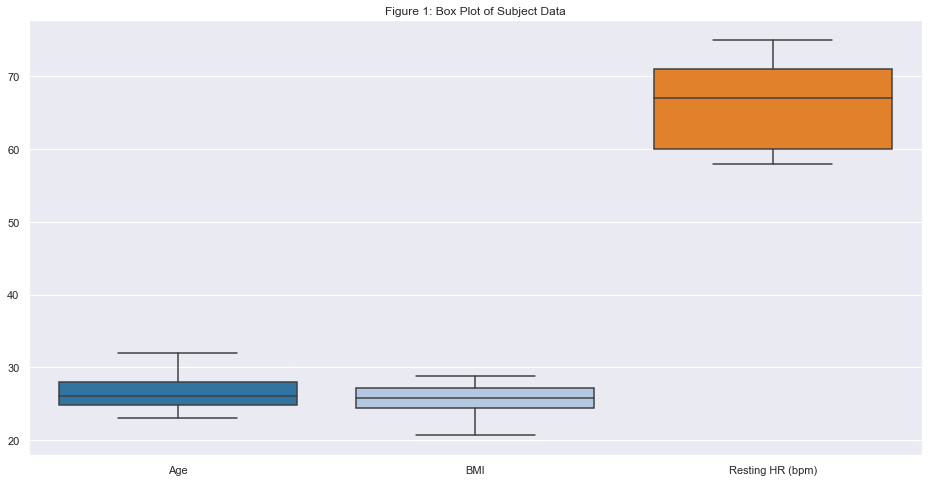

In [530]:
fig = plt.gcf()
fig.set_size_inches(16, 8)
sns.boxplot(data = subject_df[['Age','BMI','Resting HR (bpm)']]).set_title('Figure 1: Box Plot of Subject Data')

Figure 1 shows that the variance in characteristics were quite small. All participants were similar in age. The mean BMI is 25.1: a healthy BMI range is between 18.5 to 24.9 [2]. With reference to the initial subject_df, there were actually 6 participants who would be classified as overweight. Studies show that being overweight can lead to an elevated heart rate [3], so it may be the case that any insights derived are more valid for overweight individuals. The mean resting heart rate was 66.4. Recommended resting heart rates have been provided in the image below [4]. There is a good variation of fitness levels within the data: i.e. 2 instances of below average fitness, 3 instances of above average fitness, 2 instances of excellent fitness and 1 instance of good fitness; this does seem fairly representative of a real population.

<div>
   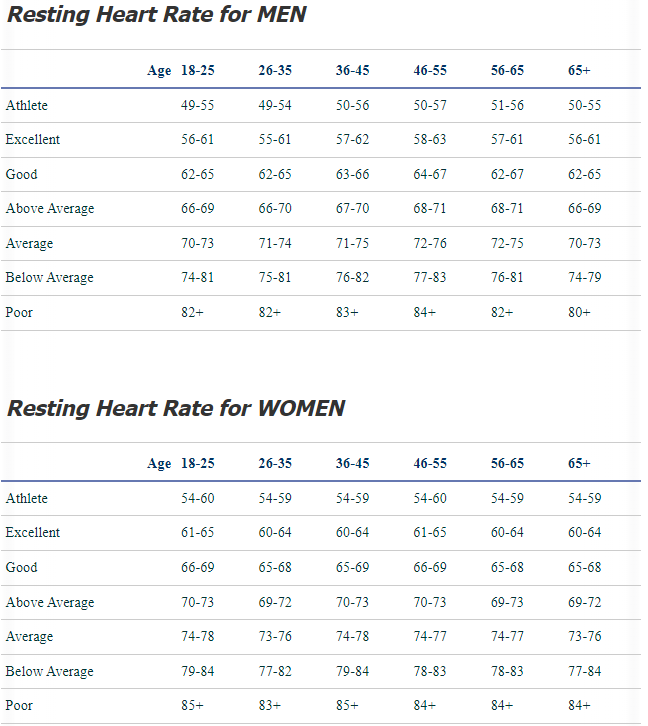
</div>

Analysis related to maximum heart rate was not considered as it appears that it is an estimate rather than a record. A common method of determining maximum heart rate is 220 - age [5] which appears to be the case within the subject_df derived above. Further analysis in section 2.6 show that there were some discrepencies for this characteristic.

### 2.5 EDA 2: Activity Distribution

In order to determine how balanced the dataset was in terms of activities, it was important to analyse the count of each activity. 

Text(0, 0.5, 'Number of Entries')

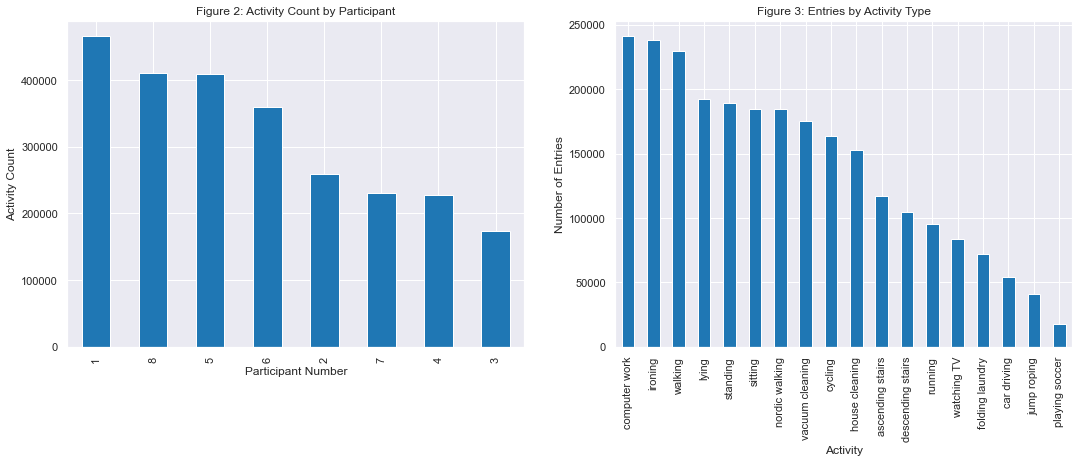

In [531]:
#df grouped by partcipant and activity count
activity_by_subject = cleaned[['ActivityID','participant']]
activity_by_subject = activity_by_subject.groupby('participant').count().sort_values('ActivityID',ascending = False)

#df grouped by activity and count from all participants
activity_count = cleaned[['ActivityID','participant']].groupby('ActivityID').count().sort_values('participant',
                                                                                                 ascending = False)
activity_count

#subplot set up
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18,6))
activity_by_subject.plot.bar(ax = axes[0])
activity_count.plot.bar(ax = axes [1])

#plot labelling
axes[0].legend()
axes[1].legend()
axes[0].get_legend().set_visible(False)
axes[1].get_legend().set_visible(False) #dont actually need a legend
axes[0].set_title('Figure 2: Activity Count by Participant')
axes[0].set_xlabel('Participant Number')
axes[0].set_ylabel('Activity Count')
axes[1].set_title('Figure 3: Entries by Activity Type')
axes[1].set_xlabel('Activity')
axes[1].set_ylabel('Number of Entries')

Figure 1 shows the number of recorded entries for each participant. It is evident that there is quite a significant difference between participants, however given that there are no less than 150,000 entries for any participant, these differences are unlikely to affect our insights as there is still sufficient data for analysis. Hopefully there should be enough data from each participant to eliminate bias between participants for any given activity.

For figure 2, activity 'playing soccer' has limited data, so it will be important to consider the effect this will have on any modelling; it may be more difficult to correctly classify this activity. In figure 4, a breakdown of each activity by the participant can be observed. The effects of bias are more easily observed here. It can be seen that some participants did not participant at all in certain activities, but many of them have enough participants to introduce some variance which hopefully eliminates bias over a particular participant's excercise method/form. For activity 11: 'car driving' and activity 9: 'computer work', there are only entries present for participant 1, which means this data may be fairly unreliable when it comes to predicting activity. Any system we create will be solely based on how participant 1 drives a car or sits at a computer. I decided to keep them at this stage, but it is a point to consider for model accuracy.

Text(0.5, 1.0, 'Figure 4: Stacked Bar Chart of Activity by Participant')

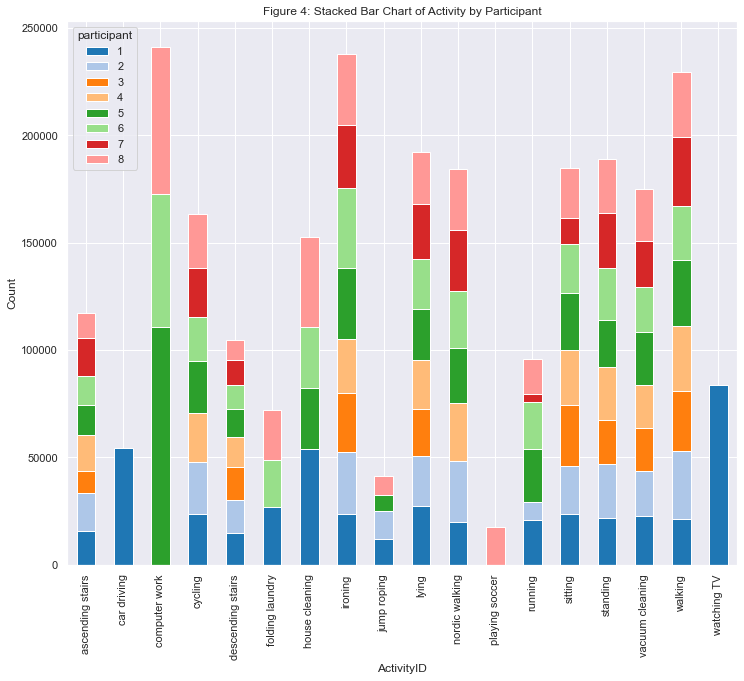

In [532]:
stacked = cleaned[['ActivityID','participant']]
stacked.groupby(['ActivityID', 'participant']).size().unstack().plot(kind='bar', stacked=True,figsize = (12,10))
plt.ylabel('Count')
plt.title('Figure 4: Stacked Bar Chart of Activity by Participant')

### 2.6 EDA 3: Heart Rate Investigation

As heart rate is likely to be an important factor in our analysis, it was important to determine the differences between both participant and activity. Figure 3 shows that there are quite small differences between the mean heart rate of each participant for all activities. There did not appear to be any correlation between the Resting Heart Rate shown in section 2.4 and the mean heart rate for all activities.

Figure 6 appears to show that more vigorous activities have a higher mean heart rate. The file 'DataCollectionProtocol' appeared to differentiate activities by a 'MET' score which represents the metabolic equivalent of task. [6] This file only contains the 'Protocol' activities however, rather than 'Optional' tasks. Using figure 6, we can estimate intensity of 'Optional Activities' by comparing heart rate of other defined MET activities. We define intensity categories as[6]:
- 0-3.0 METs is light activity
- 3.0-7.0 METs is a moderate activity 
- 7.0-10.0 METs is a vigorous activity

From the 'DataCollectionProtocol' file and figure 6, we can determine that if jump rope was marked as a vigorous activity, then it is probably the case that playing soccer was a vigorous activity too. Although with this logic, some discrepency is noted as ascending stairs and descending stairs appear to have the same mean heart rate, even though they are listed as having different MET scores (vigorous v moderate), so more investigation is required which will be seen in section 2.7.

Text(0, 0.5, 'Heart Rate (bpm)')

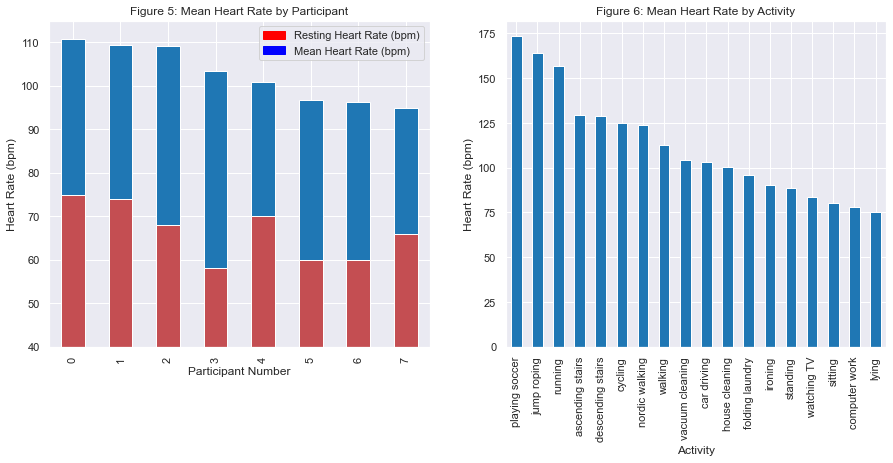

In [533]:
heart_df = cleaned[['participant', 'ActivityID','Heart Rate (bpm)']]
heart_df_subject = heart_df[['Heart Rate (bpm)','participant']].groupby('participant').mean().sort_values('Heart Rate (bpm)', ascending = False)
heart_df_activity = heart_df[['Heart Rate (bpm)','ActivityID']].groupby('ActivityID').mean().sort_values('Heart Rate (bpm)', ascending = False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,6))

heart_df_subject.plot.bar(ax = axes[0])
subject_df['Resting HR (bpm)'].plot.bar(ax=axes[0],color = 'r')
heart_df_activity.plot.bar(ax = axes [1])
axes[0].set_title('Figure 5: Mean Heart Rate by Participant')
axes[0].set_xlabel('Participant Number')
red_patch = mpatches.Patch(color='red', label='Resting Heart Rate (bpm)')
blue_patch = mpatches.Patch(color='blue', label='Mean Heart Rate (bpm)')
axes[0].legend(handles=[red_patch,blue_patch])
#axes[0].get_legend().set_visible(False)
axes[1].get_legend().set_visible(False)
axes[0].set_ylim([40,115]) #nobody had HR less than 40
axes[0].set_ylabel('Heart Rate (bpm)')
axes[1].set_title('Figure 6: Mean Heart Rate by Activity')
axes[1].set_xlabel('Activity')
axes[1].set_ylabel('Heart Rate (bpm)')

Text(0.5, 1.0, 'Figure 7: Heart Rate Heat Map by Participant and Activity')

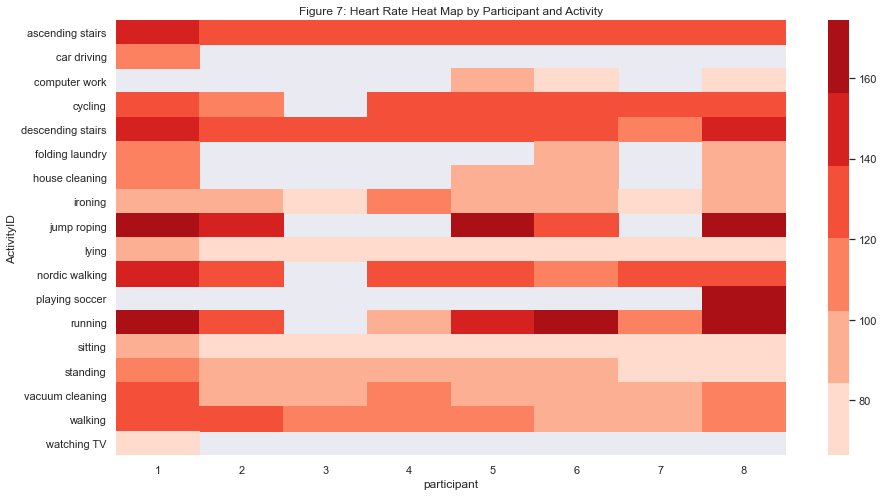

In [534]:
heart_hm = heart_df.groupby(['ActivityID','participant'], as_index = False).mean()[['ActivityID','participant','Heart Rate (bpm)']].pivot(index = 'ActivityID',columns = 'participant', values = 'Heart Rate (bpm)')
colormap = sns.color_palette("Reds")
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(heart_hm, cmap = colormap).set_title('Figure 7: Heart Rate Heat Map by Participant and Activity')

In figure 7, the variation in heart rate by participant is visualised according to activity. It does appear in general that more vigorous activities such as IDs 5,12,20,24 have a greater heart rate on average, but there is still a great deal of variation between participants.

Another interesting point to make is that participant 8 had entries where the heart rate values exceeded the maximum heart rate listed in section 2.4. This either suggests that the data entry is incorrect, or that there may be something medically wrong with the participant. In either case, we may see very skewed data for the activities that participant 8 was involved in. There were 8,855 observed activities greater than the maximum heart rate, but in light of the 400,000+ data entries for this participant it is unlikely to make much difference.

In [535]:
hc = cleaned.loc[cleaned['participant'] == 8] #change subject and id as neccessary
hc = hc.loc[hc['Heart Rate (bpm)'] > 188] 
hc

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant,Hand Acceleration,Ankle Acceleration,Chest Acceleration
1924480,3598.17,running,189.0,30.8125,-13.60620,12.90030,-0.669083,0.658724,4.291560,-2.236580,...,3.110970,1.280640,-0.067600,-25.3499,38.98720,8.64915,8,18.761506,16.011338,3.748942
1924481,3598.18,running,189.0,30.8125,-11.31600,14.92390,-1.488330,0.664550,3.915990,-1.433080,...,2.701110,1.335580,0.751084,-24.6085,38.94350,6.38249,8,18.788022,14.436863,4.798924
1924482,3598.19,running,189.0,30.8125,-9.73308,16.15060,-2.931280,0.246917,3.719480,-0.658585,...,2.546040,1.449930,1.805740,-23.6018,39.53660,6.24351,8,19.083163,11.612814,5.226643
1924483,3598.20,running,189.0,30.8125,-9.59503,16.18400,-3.314190,-0.584878,3.622940,0.094514,...,2.557330,1.647320,2.897850,-22.8529,39.36510,4.40253,8,19.104196,8.954803,4.792510
1924484,3598.21,running,189.0,30.8125,-10.17150,14.63320,-3.279110,-1.509140,3.553740,0.986832,...,2.823920,1.923860,3.610900,-20.8373,39.77500,2.84899,8,18.120224,12.358060,4.319380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2554957,1691.16,playing soccer,189.0,30.8125,-7.81944,-5.05669,3.249940,-0.049683,-0.024124,-0.006203,...,-0.003199,-0.007016,0.016110,-38.6333,-1.99203,32.90320,8,9.862853,9.981859,9.649763
2554958,1691.17,playing soccer,189.0,30.8125,-7.82506,-4.90661,3.056910,-0.049223,-0.051785,-0.008761,...,0.052002,-0.013713,0.029584,-39.2541,-2.21521,34.03600,8,9.728879,10.010245,9.864722
2554959,1691.18,playing soccer,189.0,30.8125,-7.81945,-4.67797,3.171690,-0.024362,-0.001978,-0.037746,...,0.016413,-0.003970,-0.011381,-39.0154,-1.58423,33.75240,8,9.648151,9.946219,9.822228
2554960,1691.19,playing soccer,189.0,30.8125,-7.82106,-4.71624,3.133300,-0.036467,-0.020704,-0.041851,...,0.090668,-0.024695,-0.027922,-38.7529,-1.85439,33.89550,8,9.655541,10.054921,9.870499


In [536]:
hc[['Heart Rate (bpm)','ActivityID']].groupby('ActivityID').count()

,Heart Rate (bpm)
ActivityID,
jump roping,4328
playing soccer,1412
running,3115


### 2.7 EDA 4: Activity Amount Estimation using Heart Rate Data

The project brief states that insights should be derived which enable the prospective system to determine the activity duration. This initially proved difficult as the timestamps for the 'Optional' and 'Protocol' dataset overlapped, so only the 'Protocol' sets were considered as we have accurate timestamps and durations for these activities provided in the 'DataCollectionProtocol' file.

In [537]:
#used 8 as i know they did every protocol activity
time_df_1 = cleaned[((cleaned.participant == 8) & (cleaned.ActivityID.isin([ 'lying','sitting','standing','ironing','vacuum cleaning','ascending stairs','descending stairs','walking','nordic walking','ironing','cycling','running','jump roping'])))]

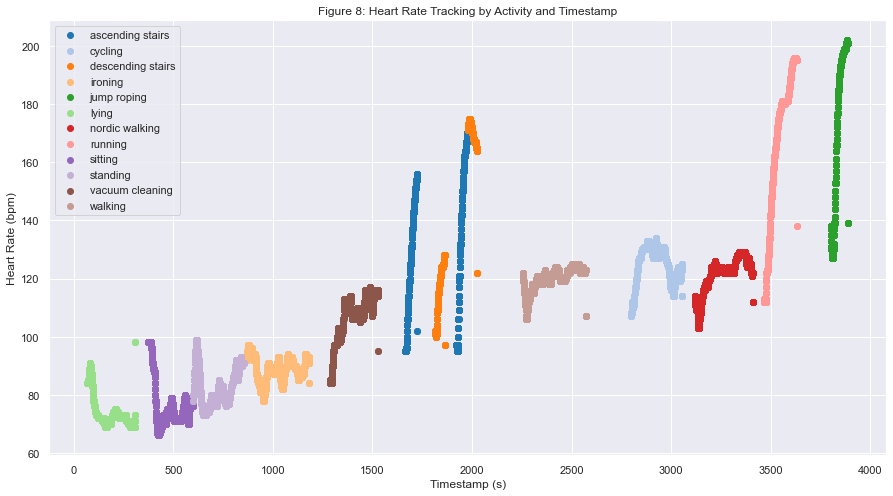

In [570]:
fig = plt.gcf()
fig.set_size_inches(15, 8)

#standard plt colors would repeat so changing default color selection
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors) 

for activity, data in time_df_1.groupby('ActivityID'):
    plt.scatter(data['Timestamp (s)'], data['Heart Rate (bpm)'], label=activity)
    plt.xlabel('Timestamp (s)')
    plt.ylabel('Heart Rate (bpm)')
    plt.title('Figure 8: Heart Rate Tracking by Activity and Timestamp')
    plt.legend()

The activity 'descending stairs' seems to be dependent on the activity 'ascending stairs': ascending stairs is an intensive activity and figure 8 shows that descending occurs directly after ascending. In the 'DataCollectionProtocol' sheet, the first occurence of descent happens after a short break when heart rate is allowed to recover, but in the second occurence of descent, it succeeds stair ascent. This is probably why we observed such close mean heart rates for the two activities in figure 6.

Interestingly, there appears to be a drop in heart rate after every activity. This is not the case for all activities however (e.g sitting, standing) so a rule based derivative system would probably have poor performance.

Instead what can be done is a comparison with the sampling frequency of the heart rate monitior. A 'windowing' system may work such that every heart rate entry is 0.111s of activity. This doesn't work with cleaned data as many entries have been removed but with an uncleaned dataset we can determine a rough estimate of the length of activity.

In [566]:
def duration_func(test_section2,participant,activity,sf):
    p1test = test_section2.loc[test_section2['participant'] == participant]
    p1test = p1test[['Heart Rate (bpm)','ActivityID']]
    dataframe_activity = p1test.loc[p1test['ActivityID'] == activity]
    
    rows_of_data = dataframe_activity.iloc[::sf,:]
    amount = len(rows_of_data)
    
    tp = 1/sf
    duration = tp*amount
    
    return duration

In [567]:
testinglying = duration_func(test_section2,8,1,9)
testinglying

298.3333333333333

In [568]:
testingstanding = duration_func(test_section2,8,3,9)
testingstanding

310.66666666666663

In [569]:
testingrunning = duration_func(test_section2,8,5,9)
testingrunning

204.1111111111111

There are various issues with this method: for example, if the activity ended before the next sample could be taken then we would potentially miss 0.111seconds of data. This method also does not consider the possibility that the same activity can be done multiple times in different periods.

### 2.8 EDA 5: Temperature Investigation  

Previous EDA task have shown that heart rate is definitely an influential feature, as was expected. Given that heart rate is likely to increase with activity intensity, temperature should also be investigated for the same measure.

In [572]:
#individual dfs for location for 3 heatmaps
temp_df = cleaned[['ActivityID','Temperature_H (C)','Temperature_A (C)', 'Temperature_C (C)','participant']]
hand_temp = temp_df.groupby(['ActivityID','participant'], as_index = False).mean()[['ActivityID','participant','Temperature_H (C)']].pivot(index = 'ActivityID',columns = 'participant', values = 'Temperature_H (C)')
ankle_temp = temp_df.groupby(['ActivityID','participant'], as_index = False).mean()[['ActivityID','participant','Temperature_A (C)']].pivot(index = 'ActivityID',columns = 'participant', values = 'Temperature_A (C)')
chest_temp = temp_df.groupby(['ActivityID','participant'], as_index = False).mean()[['ActivityID','participant','Temperature_C (C)']].pivot(index = 'ActivityID',columns = 'participant', values = 'Temperature_C (C)')

Text(0.5, 1.0, 'Figure 9c: Chest Temperature Variation')

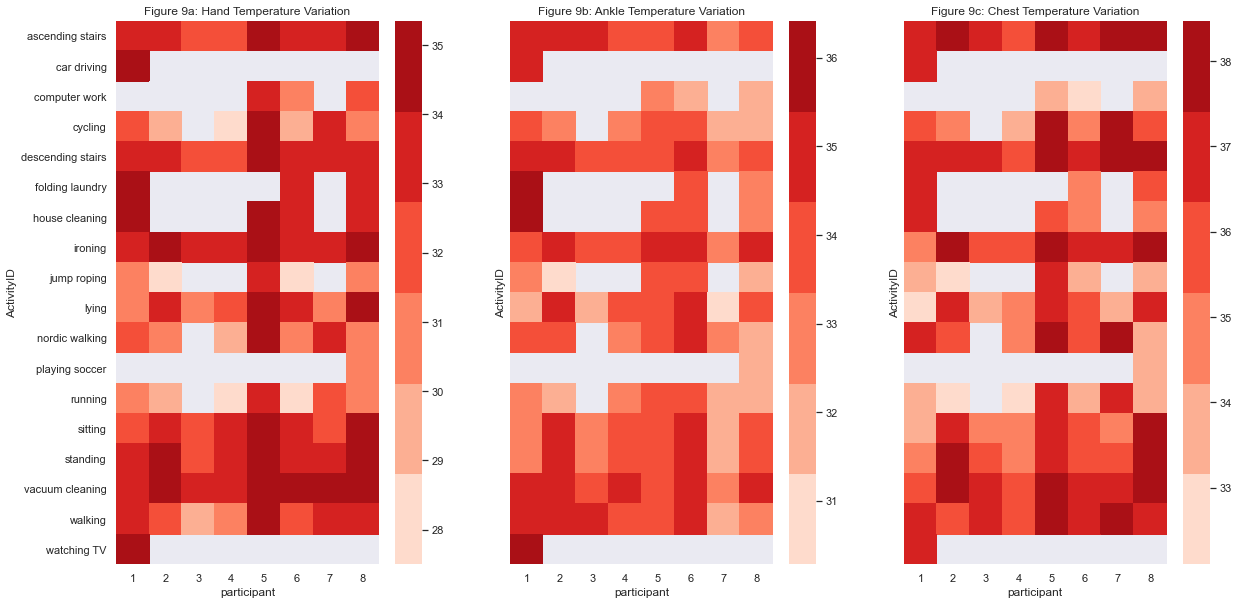

In [573]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,10),sharey=True) #conserve space by sharing y axis

sns.heatmap(hand_temp,cmap=colormap,ax = axes[0]) #colormap defined in earlier cells
sns.heatmap(ankle_temp,cmap=colormap,ax = axes[1])
sns.heatmap(chest_temp,cmap=colormap,ax = axes[2])


axes[0].set_title('Figure 9a: Hand Temperature Variation')
axes[1].set_title('Figure 9b: Ankle Temperature Variation')
axes[2].set_title('Figure 9c: Chest Temperature Variation')

There does not appear to be any pattern between temperature and activities, it is perhaps easier to differentiate by activity intensity rather than individual activities. I defined light, moderate and vigourous activities according to the reasoning given in section 2.6

In [36]:
light_list = ['lying','computer work','sitting','standing','car driving','folding laundry', 
              'house cleaning', 'ironing','watching TV']
moderate_list =['vacuum cleaning','descending stairs','walking', 'cycling','nordic walking']
vigourous_list = ['running','playing soccer','jump roping','ascending stairs']

intensity_dict = {}
for i in light_list:
    intensity_dict[i] = 'light'
    for j in moderate_list:
        intensity_dict[j] = 'moderate'
        for k in vigourous_list:
            intensity_dict[k] = 'vigourous'
            
intensity_df = temp_df
intensity_df = intensity_df.replace(intensity_dict)
intensity_df


,ActivityID,Temperature_H (C),Temperature_A (C),Temperature_C (C),participant
0,light,30.375,30.7500,32.1875,1
1,light,30.375,30.7500,32.1875,1
2,light,30.375,30.7500,32.1875,1
3,light,30.375,30.7500,32.1875,1
4,light,30.375,30.7500,32.1875,1
...,...,...,...,...,...
2566075,vigourous,30.750,31.8125,34.2500,8
2566076,vigourous,30.750,31.8125,34.2500,8
2566077,vigourous,30.750,31.8125,34.2500,8
2566078,vigourous,30.750,31.8125,34.2500,8


Text(0.5, 1.0, 'Figure 10c:Chest Temperature Variation')

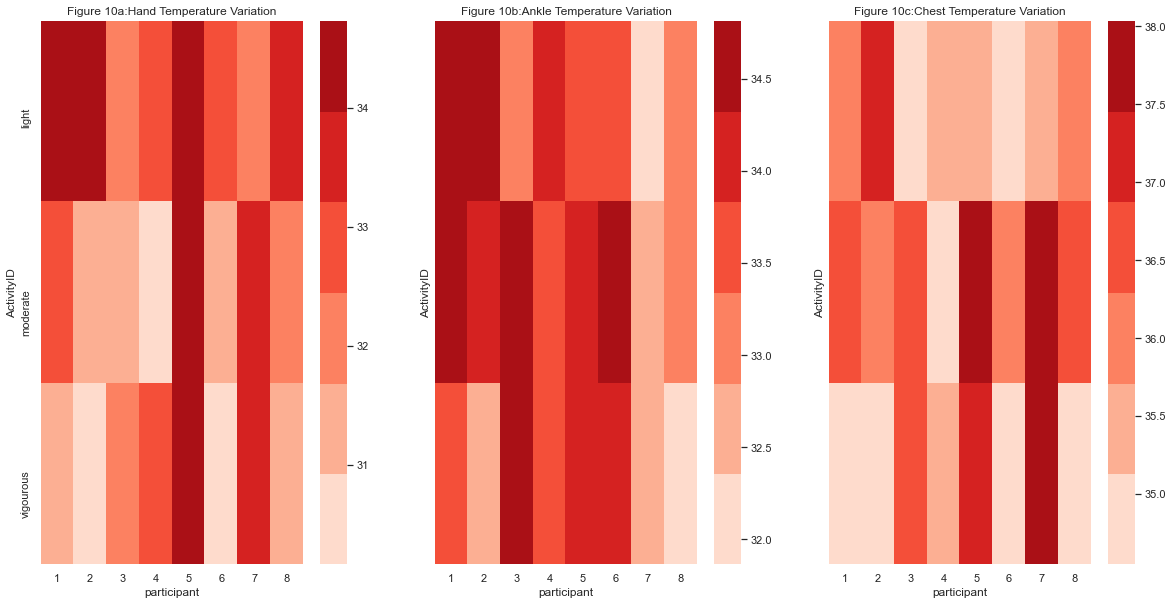

In [574]:
#careful when re-running preceding cell as same variable names, so will have to rerun the intial df cell again
hand_temp = intensity_df.groupby(['ActivityID','participant'], as_index = False).mean()[['ActivityID','participant','Temperature_H (C)']].pivot(index = 'ActivityID',columns = 'participant', values = 'Temperature_H (C)')
ankle_temp = intensity_df.groupby(['ActivityID','participant'], as_index = False).mean()[['ActivityID','participant','Temperature_A (C)']].pivot(index = 'ActivityID',columns = 'participant', values = 'Temperature_A (C)')
chest_temp = intensity_df.groupby(['ActivityID','participant'], as_index = False).mean()[['ActivityID','participant','Temperature_C (C)']].pivot(index = 'ActivityID',columns = 'participant', values = 'Temperature_C (C)')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20,10),sharey=True)

sns.heatmap(hand_temp,cmap=colormap,ax = axes[0])
sns.heatmap(ankle_temp,cmap=colormap,ax = axes[1])
sns.heatmap(chest_temp,cmap=colormap,ax = axes[2])


axes[0].set_title('Figure 10a:Hand Temperature Variation')
axes[1].set_title('Figure 10b:Ankle Temperature Variation')
axes[2].set_title('Figure 10c:Chest Temperature Variation')

There doesn't appear to be any correlation between the activity and the temperature. In figure 10a, subject 5 always has a higher hand temperature for all activity types, participant 1 gets colder for more intensive activity. No matter the sensor location, there aren't any obvious trends.

There are various reasons for the variation in temperature which decreases the value of the reading: the data package did not state whether activities were performed indoor or outdoor. Temperatures are likely to be colder outdoor. As heart rate increases, individuals are likely to sweat which actually draws heat away from the body, which is perhaps why more vigorous activities see lower temperatures in general. Either way, there seem to be too many unknown influences on temperature, so it is of limited use for this analysis.

### 2.9 EDA 6: Acceleration Investigation

Acceleration is likely to be an important feature in our modelling as the pace of activities can help determine the type of activity.

Text(0.5, 1.0, 'Figure 11f: Playing Soccer Accelerometer')

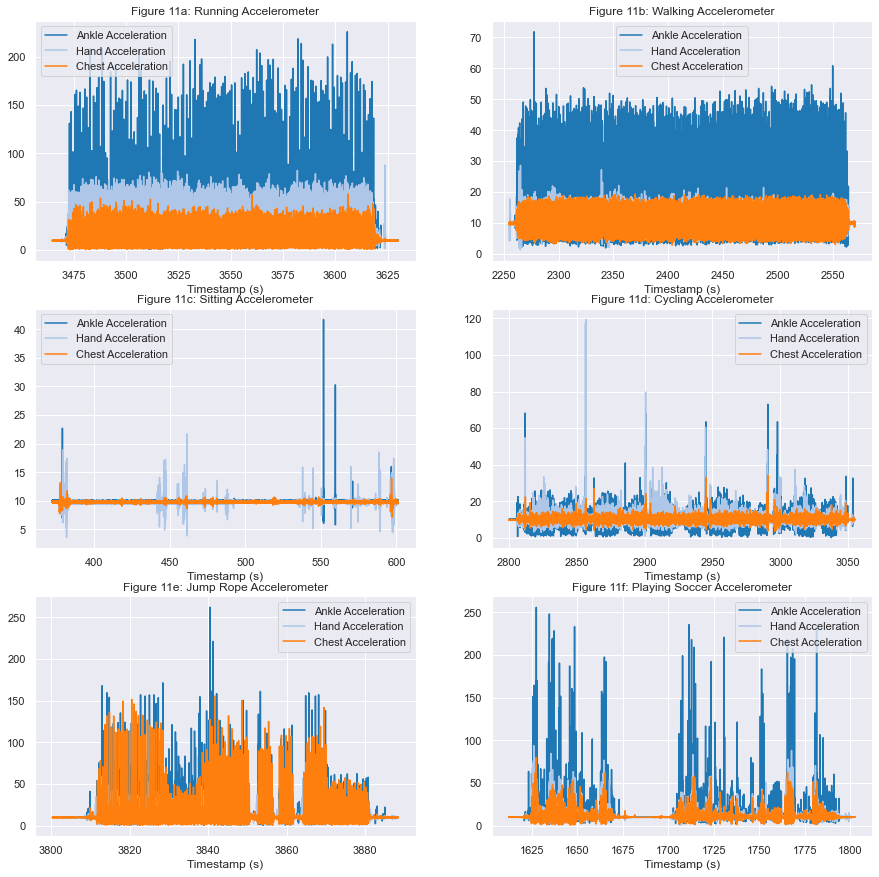

In [578]:
test = cleaned.loc[cleaned['participant'] == 8]
test_run = test.loc[test['ActivityID'] == 'running'] 
test_walk = test.loc[test['ActivityID'] == 'walking']
test_sit = test.loc[test['ActivityID'] == 'sitting']
test_cycle = test.loc[test['ActivityID'] == 'cycling']
test_jump = test.loc[test['ActivityID'] == 'jump roping']
test_soccer = test.loc[test['ActivityID'] == 'playing soccer']

fig, ax = plt.subplots(3,2,figsize = (15,15))
test_run.plot.line(x='Timestamp (s)', y = ['Ankle Acceleration','Hand Acceleration','Chest Acceleration'], ax = ax[0,0])
test_walk.plot.line(x='Timestamp (s)', y = ['Ankle Acceleration','Hand Acceleration','Chest Acceleration'], ax = ax[0,1])
test_sit.plot.line(x='Timestamp (s)', y = ['Ankle Acceleration','Hand Acceleration','Chest Acceleration'], ax = ax[1,0])
test_cycle.plot.line(x='Timestamp (s)', y = ['Ankle Acceleration','Hand Acceleration','Chest Acceleration'], ax = ax[1,1])
test_jump.plot.line(x='Timestamp (s)',y = ['Ankle Acceleration','Hand Acceleration','Chest Acceleration'], ax = ax[2,0])
test_soccer.plot.line(x='Timestamp (s)', y = ['Ankle Acceleration','Hand Acceleration','Chest Acceleration'], ax = ax[2,1])

ax[0,0].set_title('Figure 11a: Running Accelerometer')
ax[0,1].set_title('Figure 11b: Walking Accelerometer')
ax[1,0].set_title('Figure 11c: Sitting Accelerometer')
ax[1,1].set_title('Figure 11d: Cycling Accelerometer')
ax[2,0].set_title('Figure 11e: Jump Rope Accelerometer')
ax[2,1].set_title('Figure 11f: Playing Soccer Accelerometer')

In figure 11, it should be noted that all acceleration starts from 9.81 $m/s^2$ due to the effect of gravity. This could have been re-adjusted to 0, but it makes little difference in terms of modelling. There are a range of activities considered for this task, all of which are quite different in their characteristics, e.g. stationary, variable speed, constant speed.

Figure 11a represents running and shows that a fairly constant pace was maintained. The magnitude of the acceleration is fairly high compared to the other figures. Figure 11b represents walking. Evidentally it shows the same profile as figure 11a, except at a lower acceleration, because of the slower pace. Figure 11c represents sitting and shows that there is a mostly constant '0' reading for the accelerometer. Small variations are probably observed due to things such as readjusting position. In figure 11d, we notice almost periodic variations in ankle acceleration which is probably related to the downward movement applied to bicycle pedals. Figure 11e shows jump rope and reflects the minimal movement of hands in the cartesian plane, (rather they rotate almost in place which would be present in gyro data). There are small stops observed which probably represent getting tangled in the rope for instance. Figure 11f is interesting as soccer is not neccesarily constant movement which is indeed reflected in this figure. There are very significant jumps in ankle acceleration data which probably represent a kick of the ball. The magnitude of this varies according to the power of the kick. There are also times when the participant does not move, or only jogs around.

It is therefore evident that each activity has a very unique accelerometer profile which can be useful in differentiating  activities when it comes to modelling.

### 2.10 Concluding EDA

Section 2 has shown that there are various useful features which can be used to determine activity type and activity duration. While it is essentially guaranteed that other features such as gyroscope readings are likely to influence models, it is quite monotonous to explore every feature. I am satisfied that these features alone would be satisfactory to correctly classify activity with a relatively high accuracy, but will use all unexplored features to model. The validity of the statements made in this section will be further investigated in section 3.

## Section 3: Hypothesis Testing

### 3.1: Heart Rate and Vigorous Activities

The first hypothesis to consider is that of which has previously been discussed in section 2.6: *'More vigorous activities have significantly higher heart rate means than less vigorous activities'* Where the null hypothesis is: *'There is no difference between the mean heart rate of any intensity level'*.

A two tailed t-test is neccessary to determine whether there is significant difference between two means. I will be conducting tests to determine a) that vigorous intensity heart rate means are significantly higher than moderate intensity means and b) moderate means are significantly higher than light intensity means.

In [39]:
#This cell outputs the current means of the different intensities

#have to remap the intensities to clean df
mapped_intensities = cleaned.replace(intensity_dict)
mapped_intensities_mean = mapped_intensities[['ActivityID','Heart Rate (bpm)']].groupby('ActivityID').mean()
mapped_intensities_mean

,Heart Rate (bpm)
ActivityID,
light,86.072695
moderate,117.708270
vigourous,147.137418


In [41]:
#create each df with just one intensity
vig_df = mapped_intensities[mapped_intensities['ActivityID'] == 'vigourous']
vig_df = vig_df['Heart Rate (bpm)']
mod_df = mapped_intensities[mapped_intensities['ActivityID'] == 'moderate']
mod_df = mod_df['Heart Rate (bpm)']
light_df = mapped_intensities[mapped_intensities['ActivityID'] == 'light']
light_df = light_df['Heart Rate (bpm)']

By using the t-test method, we make the assumption that [7]:
1. The samples are independent
2. The samples are both normally distributed
3. The samples have same variance

It is difficult to determine whether the samples are independent because certain activities were conducted immediately after other activities (see figure 8 or section 2.7) For simplicity's sake, we will be assuming they are independent.

In [584]:
vig_sample = list(np.array(vig_df)) #rand sample has to take a list
mod_sample = list(np.array(mod_df))
light_sample = list(np.array(light_df))

sm_vig = random.sample(vig_sample, 3000) #normality p value only accurate for n < 5000 
#so lets choose 3000 random samples
sm_mod = random.sample(mod_sample,3000)
sm_lig = random.sample(light_sample,3000)

#as im only sampling a small amount of df choose different part of the sample each time
def bootstrap_sample(data):
    return [random.choice((data)) for _ in data]

#using shapiro normality method [8]
#the null hypothesis is that the data is normal
def normality(sample):
    normality_test = []
    for i in range(10):
        bs = bootstrap_sample(sample)
        st,norm = stats.shapiro(bs)
        normality_test.append(norm)
        
    return mean(normality_test)

In [585]:
print('Smaller vigorous mean:',mean(sm_vig))
print('Smaller moderate mean:',mean(sm_mod))
print('Smaller light mean:',mean(sm_lig))
#not a drastic difference

Smaller vigorous mean: 147.78133333333332
Smaller moderate mean: 117.60733333333333
Smaller light mean: 85.78666666666666


In [586]:
print('Vigorous:',normality(sm_vig))
print('Moderate:', normality(sm_mod))
print('Light:',normality(sm_lig))

Vigorous: 6.606157380377354e-23
Moderate: 3.982432771201039e-16
Light: 6.712445512140351e-19


The Shapiro-Wilkes test is only valid for samples up to N = 5000 [8], so I sampled and bootstrapped the data to test for normality. The null hypothesis is that the data is normal, so as the obtained p-values are all less than 0.05 we reject the null hypothesis and assume that the data is NOT normal. Although this was a requirement, with a large enough sample size we can ignore this.

In [45]:
print(np.var(sm_vig))
print(np.var(sm_mod))
print(np.var(sm_lig))

735.1452315555556
242.74539155555556
154.95743066666668


Variances are not the same, but we can utilise Welches t-test instead by setting the parameter 'equal_var' to False.

In [587]:
vig_v_mod = stats.ttest_ind_from_stats(vig_df.mean(),vig_df.std(),vig_df.count(),mod_df.mean(),mod_df.std(),mod_df.count(),equal_var = False)
print('The p-value for vigorous v moderate is',vig_v_mod.pvalue/2)
mod_v_lig = stats.ttest_ind_from_stats(mod_df.mean(),mod_df.std(),mod_df.count(),light_df.mean(),light_df.std(),light_df.count(),equal_var = False)
print('The p-value for moderate v light is',mod_v_lig.pvalue/2)

The p-value for vigorous v moderate is 0.0
The p-value for moderate v light is 0.0


The p-values for the two hypotheses are 0, which means the alternative hypothesis can be accepted as there is less than 5% chance, (technically could make this less than 1%,0.1%...) chance that our results are due to chance. The data definitely suggests that vigorous activities have higher heart rates on average.

### 3.2: Temperature and Heart Rate Correlation

In section 2.8, there did not appear to be any correlation with activity, and hence higher heart rate given the first hypothesis that was tested. The formal alternative hypothesis to test is therefore: *'If temperature is dependent on heart rate, then temperature will increase as heart rate increases'*. The null hypothesis is that *'Temperature is independent from heart rate'*.

The pearson correlation is: 0.0010917094905732324 and the p-value is: 0.47380589461590805
The two variables are probably independent.


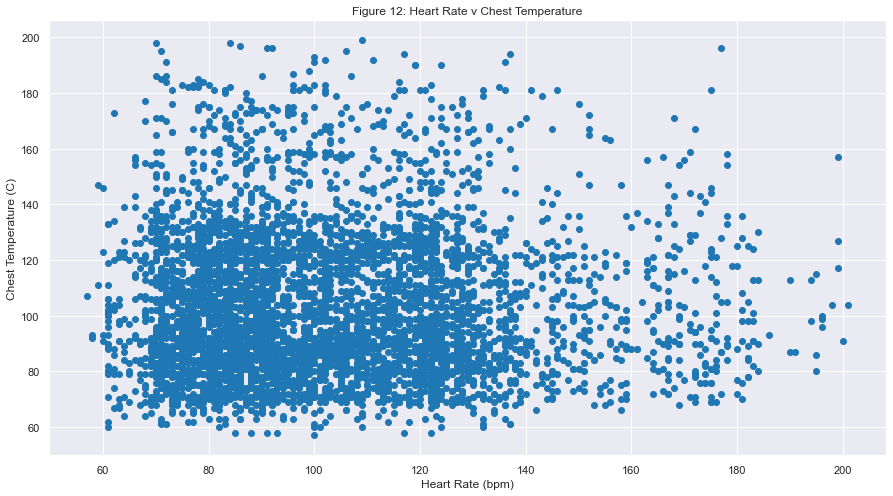

In [591]:
temp_hyp = cleaned[['Heart Rate (bpm)','Temperature_C (C)']]

chest_sam = list(np.array(temp_hyp['Temperature_C (C)']))
heart_sam = list(np.array(temp_hyp['Heart Rate (bpm)']))

chest_sample = random.sample(heart_sam,5000) #data points were too messy so smaller sample
heart_sample = random.sample(heart_sam,5000)

plt.scatter(heart_sample,chest_sample)
plt.xlabel('Heart Rate (bpm)')
plt.ylabel('Chest Temperature (C)')
plt.title('Figure 12: Heart Rate v Chest Temperature')

corr = []
pm = []

for i in range(10):
    bs1 = bootstrap_sample(chest_sample)
    bs2 = bootstrap_sample(heart_sample)
    correlation, p = stats.pearsonr(bs2,bs1)
    corr.append(correlation)
    pm.append(p)
    
print('The pearson correlation is:',mean(corr),"and the p-value is:",mean(pm))
if mean(pm) > 0.05:
    print('The two variables are probably independent.')
else:
    print('The two variables are probably dependent.')

Figure 12 shows the relationship between heart rate and chest temperature for 5000 random samples. Although hand and ankle temperature were also tested, the relationship was very similar and hence not worth differentiating for this test. Using pearson's correlation coefficient, the coefficient was almost 0, suggesting that there is virtually no correlation between the two. The p-value is much greater than 0.05 which means we accept the null hypothesis.

### 3.3: Significant Differences Between Activities

Before observing the data, I noted that the range of activities were quite specific, for example things like computer work and sitting would be quite hard to differentiate. For the activity 'Cleaning' there are many other listed activities which would come under this category e.g. ironing, folding laundry. Our data becomes much easier to model if we were to group some of these activities together, which is why it is important to determine if they are significantly different from eachother.

In [592]:
activity_hyp = cleaned[['ActivityID','Heart Rate (bpm)']].groupby('ActivityID').mean().sort_values('Heart Rate (bpm)',ascending = False)
activity_hyp

,Heart Rate (bpm)
ActivityID,
playing soccer,173.494500
jump roping,163.865001
running,156.652889
ascending stairs,129.551395
descending stairs,129.139579
cycling,124.900363
nordic walking,123.817131
walking,112.766300
vacuum cleaning,104.193529


In [593]:
act_dict = {}
act_means = {}

#get smaller sample, recalc mean
for i in activity_hyp.index:
    act = cleaned[cleaned['ActivityID'] == i]
    hr_col = list(np.array(act['Heart Rate (bpm)']))
    hr_sample = random.sample(hr_col,500)
    act_dict[i] = hr_sample
    act_means[i] = mean(hr_sample)
    

In [594]:
act_means #again accurate enough to 3 sf

{'playing soccer': 173.106,
 'jump roping': 165.75,
 'running': 157.208,
 'ascending stairs': 130.216,
 'descending stairs': 129.916,
 'cycling': 124.03,
 'nordic walking': 123.918,
 'walking': 112.536,
 'vacuum cleaning': 103.52,
 'car driving': 103.116,
 'house cleaning': 100.304,
 'folding laundry': 96.074,
 'ironing': 89.436,
 'standing': 88.612,
 'watching TV': 83.954,
 'sitting': 80.756,
 'computer work': 78.074,
 'lying': 76.056}

In [595]:
for i in act_dict:
    var = np.var(act_dict[i])
    print('The variance of activity', i, 'is:', var) #so use welches test

The variance of activity playing soccer is: 426.734764
The variance of activity jump roping is: 499.3275
The variance of activity running is: 458.560736
The variance of activity ascending stairs is: 413.67734400000006
The variance of activity descending stairs is: 550.4849439999999
The variance of activity cycling is: 97.1171
The variance of activity nordic walking is: 132.62727600000002
The variance of activity walking is: 95.232704
The variance of activity vacuum cleaning is: 170.56560000000002
The variance of activity car driving is: 54.79854399999999
The variance of activity house cleaning is: 136.279584
The variance of activity folding laundry is: 67.33652400000001
The variance of activity ironing is: 73.27790399999999
The variance of activity standing is: 94.661456
The variance of activity watching TV is: 38.755883999999995
The variance of activity sitting is: 75.064464
The variance of activity computer work is: 57.212523999999995
The variance of activity lying is: 106.3408639999

In [596]:
ttest_to_df = []
idxs = []

for i in act_dict:
    idxs.append(i)
    for j in act_dict:
        ttest_data = stats.ttest_ind_from_stats(mean(act_dict[i]),stdev(act_dict[i]),len(act_dict[i]), mean(act_dict[j]),stdev(act_dict[j]),len(act_dict[j]), equal_var = True)
        ttest_to_df.append(ttest_data.pvalue)


In [597]:
ttest_to_df = np.reshape(ttest_to_df,(18,18))

In [598]:
comp_act = pd.DataFrame(data= ttest_to_df,index = idxs, columns = idxs)
comp_act.round(decimals=4)

,playing soccer,jump roping,running,ascending stairs,descending stairs,cycling,nordic walking,walking,vacuum cleaning,car driving,house cleaning,folding laundry,ironing,standing,watching TV,sitting,computer work,lying
playing soccer,1.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000
jump roping,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000
running,0.0,0.0,1.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000
ascending stairs,0.0,0.0,0.0,1.0000,0.8292,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000
descending stairs,0.0,0.0,0.0,0.8292,1.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000
cycling,0.0,0.0,0.0,0.0000,0.0000,1.0000,0.8689,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000
nordic walking,0.0,0.0,0.0,0.0000,0.0000,0.8689,1.0000,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000
walking,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,1.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000
vacuum cleaning,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,1.0000,0.5479,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000
car driving,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.5479,1.0000,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0000


The results are very interesting and verify some of the previous assumptions noted in section 2.7. Activities 'ascending stairs' and 'descending stairs' showed that the results were not significantly different from one another as they have a p-value of 0.8292 when compared. This highlights the previous issues that the heart rate may not be independent between the activities. 'Standing' and 'Ironing' can be considered as statistically insignificant differences which makes sense as the only difference between the two activities would be hand movements.'Car driving' and 'vacuum cleaning' were considered as not significantly different too which was quite unexpected, as was 'Nordic Walking' and 'Cycling'.

It is difficult to tell whether these activities are possible to differentiate at this stage as there are many other features which can be used to train a classifier beyond heart rate. Instead of merging the activities, I will analyse the effect these statistical findings have on the precision and recall of the classifier for the activities outlined above.

## Section 4: Modelling

In this section I will attempt to use the Random Forest and KMeans clustering methods to correctly classify activity.

### 4.1: Dimensionality and Sample Reduction

As it currently stands there are 37 columns of data. This dimensionality is far too complex to model with. We can eliminate some columns by simple logic e.g. timestamp is not connected with the type of activity, it is an arbitrary value to monitor progress. There is no need to differentiate by participant, and it was already determined that the temperature column was fairly insignificant.

The first step to reduce overall data was to eliminate the start and end of an activity. These are relatively transient periods where the activity is not happening. Although 30 seconds of the data from either side have been eliminated, this may remove actual information about the activity. This does however ensure that we only have data where that activity is definitely happening, with the exception of 'ascending' and 'descending'.

In [306]:
idxs = []
#this doesn't account for multiple activities done e.g ascending descending, but should capture overall idea
for j in range(1,9):
    for i in act_dict:
     #8 participants
        activity_df = cleaned[cleaned['ActivityID'] == i] #get activity df
        for_participant = activity_df[activity_df['participant'] == j] #then get participant for one activity
        first_idxs = np.asarray(for_participant[:3000].index) #get first 30 secs of data
        last_idxs = np.asarray(for_participant[-3000:].index) #get last 30 secs of data
        idxs.extend([first_idxs,last_idxs])   

In [307]:
flat_list = [item for sublist in idxs for item in sublist]
start_end_dropped = cleaned.drop(flat_list,axis=0)

In [308]:
start_end_dropped

,Timestamp (s),ActivityID,Heart Rate (bpm),Temperature_H (C),3DaccH1_16,3DaccH2_16,3DaccH3_16,3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,...,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,participant,Hand Acceleration,Ankle Acceleration,Chest Acceleration
3000,67.66,lying,100.0,30.6875,6.04289,4.98560,5.54051,-0.005100,0.009256,0.023031,...,0.016006,0.006970,0.020230,-13.6674,45.1846,-6.63805,1,9.595310,10.131352,9.702424
3001,67.67,lying,100.0,30.6875,6.12114,4.98569,5.61866,0.019801,-0.030706,0.013710,...,-0.019115,0.028426,0.010098,-13.7790,45.0798,-6.76204,1,9.689933,10.041853,9.668236
3002,67.68,lying,100.0,30.6875,6.12061,4.90981,5.61891,0.010058,-0.026232,0.000358,...,0.024533,-0.017164,-0.002818,-13.8808,44.4199,-6.64446,1,9.650920,10.066084,9.745773
3003,67.69,lying,100.0,30.6875,6.20341,4.98679,5.81232,0.014155,-0.028553,0.004515,...,0.020319,0.010627,-0.001781,-14.3259,44.7535,-5.64704,1,9.855630,10.123946,9.451569
3004,67.70,lying,100.0,30.6875,6.12114,4.98569,5.61866,0.014067,0.005227,-0.013615,...,0.068253,-0.034286,-0.013104,-13.8846,44.9651,-6.14350,1,9.689933,10.259955,9.537047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562954,1771.13,playing soccer,182.0,30.8125,-8.38758,1.84990,2.87174,-0.945420,-1.206060,-2.268720,...,2.142150,0.532291,-0.040932,-37.3893,-14.1653,29.80140,8,9.056518,10.977998,9.328780
2562955,1771.14,playing soccer,182.0,30.8125,-8.06273,2.14643,2.37527,-0.951695,-1.197600,-2.291090,...,2.661780,0.532162,-0.060047,-38.0381,-13.3588,30.36550,8,8.675061,10.601189,9.211507
2562956,1771.15,playing soccer,182.0,30.8125,-7.96006,2.33223,2.02980,-0.952514,-1.116120,-2.307690,...,3.053020,0.487765,-0.088580,-38.1877,-12.3214,30.36380,8,8.539434,10.171370,9.313063
2562957,1771.16,playing soccer,182.0,30.8125,-7.82576,2.78130,1.45298,-1.007300,-1.098090,-2.286100,...,3.392200,0.390456,-0.146105,-37.9236,-12.5912,30.64870,8,8.431447,9.969411,9.375431


In [601]:
unlabelled_set = start_end_dropped.drop(['Timestamp (s)','participant','3DaccH1_16','3DaccH2_16','3DaccH3_16',
                                        '3DaccA1_16','3DaccA2_16','3DaccA3_16','3DaccC1_16','3DaccC2_16','3DaccC3_16','Temperature_H (C)',
                                         'Temperature_C (C)','Temperature_A (C)'], axis=1)
unlabelled_set # don't want to drop activity ID at the moment as going to shuffle data and want activity to shuffle with it

,ActivityID,Heart Rate (bpm),3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,3Dmag_H1,3Dmag_H2,3Dmag_H3,3Dgyro_C1,3Dgyro_C2,...,3Dmag_C3,3Dgyro_A1,3Dgyro_A2,3Dgyro_A3,3Dmag_A1,3Dmag_A2,3Dmag_A3,Hand Acceleration,Ankle Acceleration,Chest Acceleration
3000,lying,100.0,-0.005100,0.009256,0.023031,-14.2349,15.08130,-58.1632,0.008244,-0.037095,...,-54.708800,0.016006,0.006970,0.020230,-13.6674,45.1846,-6.63805,9.595310,10.131352,9.702424
3001,lying,100.0,0.019801,-0.030706,0.013710,-14.1295,14.20630,-58.2895,0.012170,-0.019094,...,-54.946800,-0.019115,0.028426,0.010098,-13.7790,45.0798,-6.76204,9.689933,10.041853,9.668236
3002,lying,100.0,0.010058,-0.026232,0.000358,-14.0273,15.18850,-58.9745,0.027844,-0.005621,...,-54.708500,0.024533,-0.017164,-0.002818,-13.8808,44.4199,-6.64446,9.650920,10.066084,9.745773
3003,lying,100.0,0.014155,-0.028553,0.004515,-14.1205,15.18200,-58.0477,-0.009061,-0.025676,...,-54.350700,0.020319,0.010627,-0.001781,-14.3259,44.7535,-5.64704,9.855630,10.123946,9.451569
3004,lying,100.0,0.014067,0.005227,-0.013615,-13.9149,14.85410,-58.8637,0.005565,-0.073869,...,-54.707300,0.068253,-0.034286,-0.013104,-13.8846,44.9651,-6.14350,9.689933,10.259955,9.537047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562954,playing soccer,182.0,-0.945420,-1.206060,-2.268720,46.9706,8.04028,-24.7800,0.082125,0.877344,...,-1.036390,2.142150,0.532291,-0.040932,-37.3893,-14.1653,29.80140,9.056518,10.977998,9.328780
2562955,playing soccer,182.0,-0.951695,-1.197600,-2.291090,47.9508,9.47667,-25.4469,0.110783,0.782330,...,-0.894867,2.661780,0.532162,-0.060047,-38.0381,-13.3588,30.36550,8.675061,10.601189,9.211507
2562956,playing soccer,182.0,-0.952514,-1.116120,-2.307690,47.0691,10.26840,-25.3186,0.135214,0.720972,...,-1.318010,3.053020,0.487765,-0.088580,-38.1877,-12.3214,30.36380,8.539434,10.171370,9.313063
2562957,playing soccer,182.0,-1.007300,-1.098090,-2.286100,46.6908,11.15670,-26.1107,0.112044,0.787550,...,-1.449940,3.392200,0.390456,-0.146105,-37.9236,-12.5912,30.64870,8.431447,9.969411,9.375431


In [602]:
unlabelled_set = unlabelled_set.sample(frac=1) #shuffles data to increase randomness
train, test = train_test_split(unlabelled_set, test_size=0.3) #still has labels

In [603]:
labels_train = train['ActivityID']
labels_test = test['ActivityID'] #going to add these back at the end to see if labels are correctly classified

train = train.drop(['ActivityID'],axis = 1) #drops labels
test = test.drop(['ActivityID'],axis = 1) #drops labels

The data was split into training and test data. All features were then scaled as many of them rely on a scale and are of different magnitudes. Research shows that scaling features eliminates a bias being given to larger scales/magnitudes. [9]

In [605]:
scaler = StandardScaler()
trainer = scaler.fit_transform(train)
tester = scaler.fit_transform(test)

PCA is a method of dimensionality reduction which allows us to combine features into a representation such that the more important relationships between features are found. The intuition is that less important features will be dropped, whilst still maintaining a high percentage of information about the data.

In [606]:
pca = PCA()
pca_train = pca.fit(trainer) #pca on training set
pca_test = pca.fit(tester) #pca on test set

In [607]:
np.set_printoptions(suppress=True)
pcs = pca_train.explained_variance_ratio_
pcs

array([0.12778187, 0.09189541, 0.09132458, 0.07495824, 0.06951036,
       0.06083099, 0.05328975, 0.04840176, 0.04207101, 0.03995818,
       0.03778903, 0.03352925, 0.03293225, 0.02823971, 0.02731028,
       0.02497466, 0.02321364, 0.02245295, 0.02097894, 0.01931683,
       0.01527265, 0.01396767])

The initial PCA finds 22 principle components, which is obvious given there were 22 features in the training set. All of the components add up to 1. The first component represents 12.7% of the variability of the data, the next 9.2% and so on.

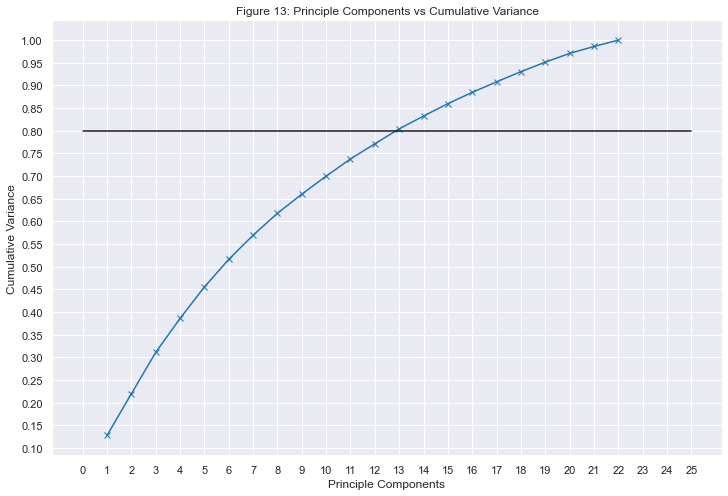

In [616]:
plt.figure(figsize = (12,8))
plt.plot(range(1,23),pcs.cumsum(),marker = 'x')
plt.xlabel('Principle Components')
plt.ylabel('Cumulative Variance')
plt.title('Figure 13: Principle Components vs Cumulative Variance')
xmax = [0,25]
ymax = [0.80,0.80]
plt.plot(xmax,ymax,color = 'k')
xlab = plt.xticks(np.arange(0,26, 1.0))
ylab = plt.yticks(np.arange(0.1,1.05,0.05))

By analysing the cumalative variance that occurs with increase in principle components, the ideal number of components to keep is found. Figure 13 shows that with 6 components, just over 50% of the information about the dataset remains. It is recommended that 80-85% of the variance is kept to preserve enough information [10]. Thus, a good number of components to keep is 14.

In [617]:
#keeping just 14 components
pca = PCA(n_components = 14)
pca_train = pca.fit(trainer)
pca_test = pca.fit(tester)

In [618]:
pcs = pca_train.explained_variance_ratio_
pcs

array([0.12778187, 0.09189541, 0.09132458, 0.07495824, 0.06951036,
       0.06083099, 0.05328975, 0.04840176, 0.04207101, 0.03995818,
       0.03778903, 0.03352925, 0.03293225, 0.02823971])

In [619]:
X_train = pca_train.transform(trainer) #transform test and train by pca reduction
X_test = pca_test.transform(tester)

### 4.2: Random Forest Classifier

The Random Forest Classifier is a decision tree method which works by taking multiple samples of the training data, creating a decision tree for each sample and prediction the class. It then looks at all the decision trees it has created, and classifies according the the most common class prediction. [11]

In [626]:
sc = []
for i in range(1,12,1):
    clf = RandomForestClassifier(n_estimators=i,n_jobs = -1) #n_jobs is the number of processes to run in parallel
    #by setting n_jobs to -1, basically say 'use as many as you want'; leads to very fast calculation
    clf.fit(X_train,labels_train)
    preds = clf.predict(X_test)

    acsc = accuracy_score(labels_test,preds)
    sc.append(acsc)

Text(0.5, 1.0, 'Figure 14: Accuracy for Number of Estimators')

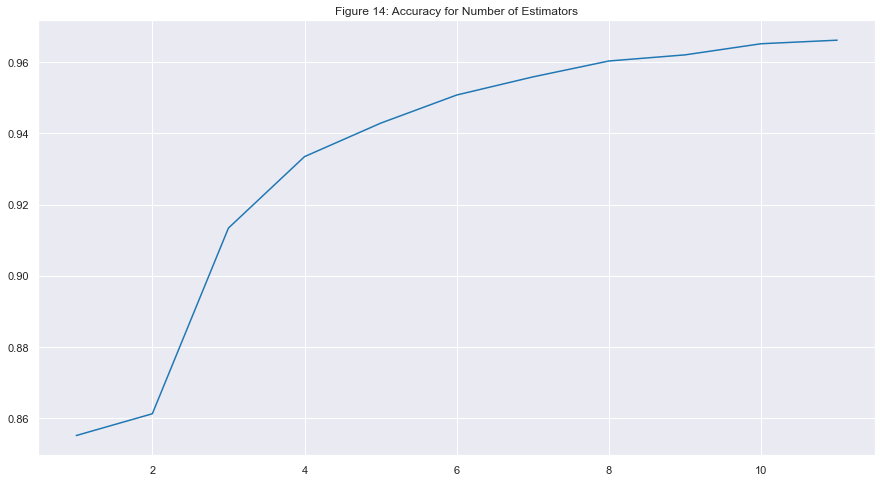

In [628]:
plt.plot(range(1,12,1),sc)
plt.title('Figure 14: Accuracy for Number of Estimators')

Figure 14 shows that the number of trees to build and average will affect the accuracy of the model. The increase in accuracy begins to plateau after 10 trees, so there isn't much point using a higher number than this.

In [629]:
clf = RandomForestClassifier(n_estimators=10,n_jobs = -1)
clf.fit(X_train,labels_train)
preds = clf.predict(X_test)
print(accuracy_score(labels_test,preds))

0.9638366786590182


In [631]:
#confusion_matrix(labels_test, preds) #uncomment to see array

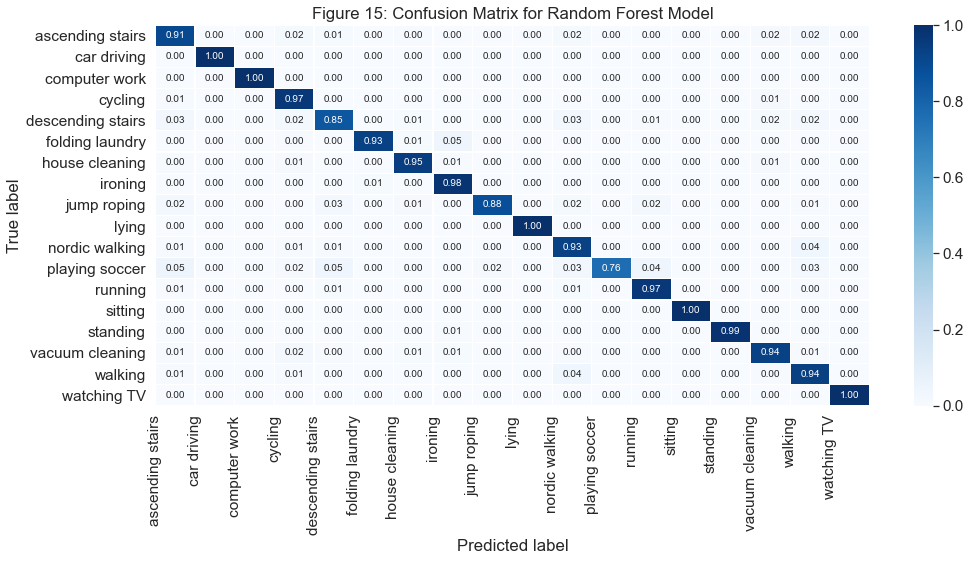

In [633]:
#confusion plotting taken from reference 11
confusion_matrix(labels_test, preds)
matrix = confusion_matrix(labels_test, preds)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] #standardise score for heatmap

#plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2, fmt='.2f')

#labels
class_names = ['ascending stairs','car driving', 'computer work','cycling','descending stairs', 'folding laundry',
               'house cleaning','ironing','jump roping','lying','nordic walking','playing soccer','running','sitting',
               'standing','vacuum cleaning','walking','watching TV']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Figure 15: Confusion Matrix for Random Forest Model')
plt.show()

In [634]:
print(classification_report(labels_test,preds))

                   precision    recall  f1-score   support

 ascending stairs       0.89      0.91      0.90     20839
      car driving       1.00      1.00      1.00     14553
    computer work       1.00      1.00      1.00     66893
          cycling       0.92      0.97      0.94     36222
descending stairs       0.90      0.85      0.88     16850
  folding laundry       0.95      0.93      0.94     16316
   house cleaning       0.96      0.95      0.96     38720
          ironing       0.96      0.98      0.97     56793
      jump roping       0.97      0.88      0.92      5059
            lying       1.00      1.00      1.00     43371
   nordic walking       0.92      0.93      0.93     42561
   playing soccer       0.96      0.76      0.85      3456
          running       0.97      0.97      0.97     18889
          sitting       1.00      1.00      1.00     40991
         standing       1.00      0.99      0.99     42183
  vacuum cleaning       0.94      0.94      0.94     38

The final accuracy was 96% which does appear to be fairly high, although given the amount of data we had to train with, this is not completely suprising. The accuracy of each activity does appear to vary slightly. The lowest F1 scores were observed for activities: 'playing soccer','nordic walking' and 'ascending/descending stairs'.

The discrepencies in playing soccer are most likely described by the limited amount of data present in the test set, and in the entire dataset as a whole. As described throughout section 2 and 3, this activity was only performed by participant 8, so it is quite limited. Figure 15 shows that it was most often alternatively predicted as another vigorous activity such as running or ascending stairs. The discrepencies of nordic walking may be explained by the results seen in section 3.3, where the heart rate mean was not statistically significant compared to cycling. Figure 15 does show that nordic walking was sometimes classified as cycling, however it was most commonly classified as walking. This is understandable as they are very similar activities. The dataset source describes different paces of walking, so it may be the case that the faster paced walking entries are being confused with nordic walking.The issue with stair ascent and descent are clearly highlighted here as they both have lower F1 scores. Stair descent is often classified as stair ascent.

In general, incorrectly predictions are often classified as another activity within the same intensity bracket. Looking at cross-validation methods, the accuracy remains the same.

In [635]:
#last step is to use cross validation to ensure results are representative.
#rfc is a stochastic method so we will see some variation of course
print(np.mean(cross_val_score(clf, X_train, labels_train, cv = 10)))

0.9621035452612633


### 4.3: Clustering Attempt

In this section I will be briefly evaluating clustering to see if any insights are possible. I do not expect it to be particularly useful as it is an unsupervised method which means it shouldn't be compared to the labels or 'ground truth' because unsupervised methods should only be used when we do not know the ground truth. 

In [636]:
inert = [] #takes about 8 mins to train

for i in range(1,18):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_train)
    inert.append(kmeans.inertia_)

With K-Means clustering, the number of required clusters is unknown. By using the inertia measure of sklearn, we can determine whether the clustering will be good. The elbow method can be used to find the optimal point. In general it is a point with low inertia for a low number of clusters. [12]

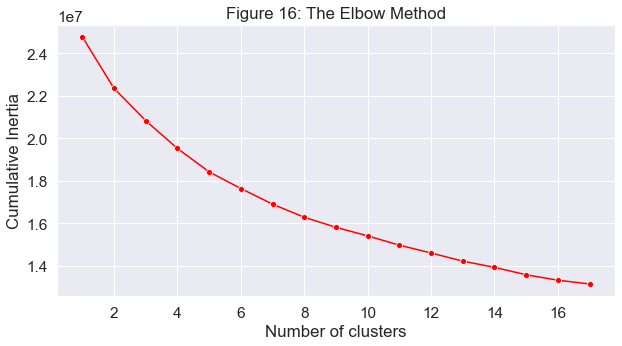

In [637]:
plt.figure(figsize=(10,5))
r = range(1,18)
sns.lineplot(x= r,y= inert,marker='o',color='red')
plt.title('Figure 16: The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Cumulative Inertia')
plt.show()

In [638]:
kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
kmeans_pca.fit(X_train)

KMeans(n_clusters=3, random_state=42)

In [644]:
train['ActivityID'] = labels_train

In [645]:
km_df = pd.concat([train.reset_index(drop=True),pd.DataFrame(X_train)], axis = 1)
km_df.columns.values[-14:] = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']
km_df['Cluster Number'] = kmeans_pca.labels_

In [647]:
km_df

,Heart Rate (bpm),3Dgyro_H1,3Dgyro_H2,3Dgyro_H3,3Dmag_H1,3Dmag_H2,3Dmag_H3,3Dgyro_C1,3Dgyro_C2,3Dgyro_C3,...,C6,C7,C8,C9,C10,C11,C12,C13,C14,Cluster Number
0,84.0,-1.251000,0.466098,0.939829,19.85640,-2.442430,-49.4644,-0.317476,0.372823,0.070552,...,0.308037,0.428738,0.441223,-0.089505,-0.792227,-0.845121,0.157182,-0.539995,0.456467,2
1,90.0,0.978011,0.347156,1.382060,27.73250,-21.735200,-16.2210,0.215977,0.975442,-0.713512,...,2.700175,-0.857382,-2.233222,2.359045,-0.145996,0.432148,-0.660372,-1.897675,0.475824,1
2,111.0,1.156850,-0.387069,0.220107,35.73610,0.689804,-36.5236,0.088026,0.206534,-0.349814,...,-1.408639,-0.022449,-0.366803,0.903821,0.671513,0.556862,-0.124913,-1.055370,0.972801,1
3,103.0,-0.198363,0.819123,-1.791660,48.24820,11.078400,-19.0268,0.384720,-0.271350,0.260485,...,-1.066942,-1.774086,-0.221470,-1.471889,-0.481692,-0.868701,-0.701685,-0.062890,0.031762,1
4,84.0,-0.030957,-0.001140,-0.003546,15.51600,-7.036060,-28.1681,0.035154,0.030127,-0.037307,...,0.019888,-0.222647,-0.127163,0.002367,-0.119964,0.276078,0.110332,-0.179924,0.236058,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352892,122.0,-1.358880,0.404293,-0.368779,31.23750,-11.112600,-44.0543,0.804028,0.502551,-0.288310,...,0.607512,-1.103175,-1.640493,-0.284370,0.093079,-0.714088,0.565260,0.166135,0.143415,1
1352893,69.0,0.031997,0.010085,-0.000690,-4.00931,5.668590,-32.1426,-0.033417,-0.014042,0.021495,...,-0.474958,-0.354721,0.102287,0.021933,-0.377300,0.416430,0.034301,0.273080,-0.186508,0
1352894,82.0,-0.024050,0.041768,0.031354,15.39210,-57.824000,-22.8337,0.011378,0.019284,-0.031613,...,0.668194,0.716787,0.004744,0.126583,0.681139,-1.985103,-0.718930,-0.524551,-0.364052,2
1352895,60.0,0.036657,0.021048,-0.030357,-5.75863,16.185400,-33.2527,0.069849,-0.009931,-0.004502,...,0.311539,0.303237,0.001418,-0.049808,0.044901,0.170565,-0.043136,0.276084,-0.181249,0


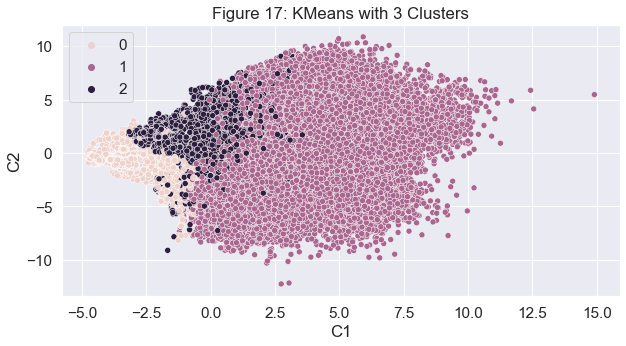

In [648]:
x_axis = km_df['C1']
y_axis = km_df['C2']
plt.figure(figsize=(10,5))
sns.scatterplot(x_axis,y_axis,hue= km_df['Cluster Number']).set_title('Figure 17: KMeans with 3 Clusters')
plt.legend()

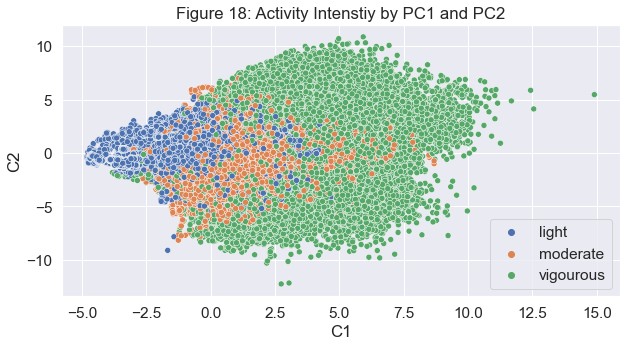

In [649]:
by_act = km_df.replace(intensity_dict)
plt.figure(figsize=(10,5))
sns.scatterplot(x_axis,y_axis,hue= by_act['ActivityID']).set_title('Figure 18: Activity Intenstiy by PC1 and PC2')
plt.legend()

As the optimal clusters was suggested as 3, I decided to compare this to the intensity categories rather than activity categories. Although in theory clustering shouldn't be compared to the ground truth, we can see from figure 17 and 18 that the clustering is fairly similar to the plot of activity intensity for the first two principle components. The data points are very close together though which means clustering is not recommended. This was also trialled for different principle components and the distance between clusters did not increase.

In [651]:
kmeans_pca2 = KMeans(n_clusters = 16, init = 'k-means++', random_state = 42)
kmeans_pca2.fit(X_train)

KMeans(n_clusters=16, random_state=42)

In [652]:
km_df2 = pd.concat([train.reset_index(drop=True),pd.DataFrame(pca_scores)], axis = 1)
km_df2.columns.values[-6:] = ['C1','C2','C3','C4','C5','C6']
km_df2['Cluster Number'] = kmeans_pca2.labels_

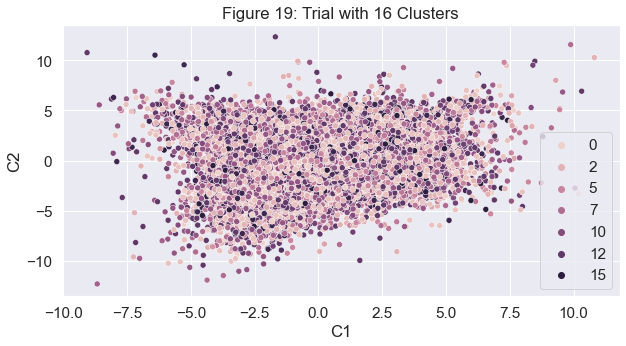

In [656]:
x_axis = km_df2['C1']
y_axis = km_df2['C2']
plt.figure(figsize=(10,5))
plt.title('Figure 19: Trial with 16 Clusters')
sns.scatterplot(x_axis,y_axis,hue= km_df2['Cluster Number'])
plt.legend(loc = 'lower right')

Text(0.5, 1.0, 'Figure 20: Activity Comparisons with 2 Principle Components')

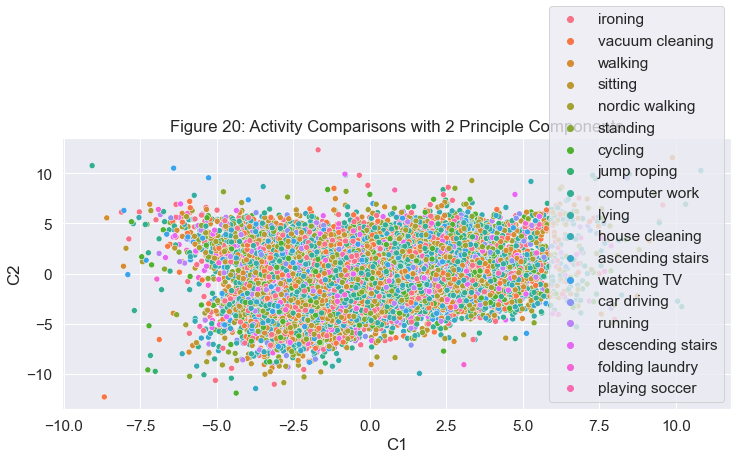

In [657]:
plt.figure(figsize=(12,5))
sns.scatterplot(x_axis,y_axis,hue= km_df['ActivityID'])
plt.legend(loc = 'lower right')
plt.title('Figure 20: Activity Comparisons with 2 Principle Components')

Out of curiosity a larger number of clusters was trialled, but evidently this will not work as shown in figures 19 and 20. The clustering algorithm fails to even find more than 7 clusters. It may be the case that further dimensionality reduction is required as figure 20 show no obvious regions where the data could be differentiated, or it may just be that unsupervised methods are a poor choice for classification problems.

## Section 5: Conclusion and Further Work

Overall, the accuracy from the Random Forest model was more than satisfactory. Given that the dataset was quite dirty, it is very likely that there are still errors within the data caused by a sensor drop or improper callibration, so it was still impressive that such high accuracy was achieved. I don't think there is an overfitting issue as the dataset was not very imbalanced with the exception of one or two activities.

There were other issues within the dataset not addressed, for example it was not stated whether the participants were healthy or not which poses issues especially with the heart rate outliers for participant 8. As discussed in section 2.4, 75% of the participants are classed as overweight which may make our model invalid for the general public. As a further task I would like to create individual participant models to see if predictions drastically change from one set of participant data to another, especially between ideal weight and overweight individuals. This is of course providing that we have the same set of activities for each participant. Given more time, I would have also liked to see the effect of removing the second instance of stair descent to see if the accuracy improves as the issues surrounding this activity were clearly affecting the accuracy. 

I believe that the insights derived in this project could indeed be used for human activity recognition software or hardware. Of course I would like to implement an automated duration feature, however when considering what is available on current devices e.g. Apple Watch, I came to the conclusion that the user either manually selects whether they have begun activity, or the software detects a raise in heart rate and or rapid movement which leads me to believe that any system I made would not work with sedentary activities such as sitting, standing and lying.

# References

__[1]__ A. Reiss and D. Stricker. Introducing a New Benchmarked Dataset for Activity Monitoring. The 16th IEEE International Symposium on Wearable Computers (ISWC), 2012.<br><br>
__[2]__ CDC - Centres for Disease Control and Prevention. Assessing Your Weight, 2021. [online] Available at:https://www.cdc.gov/healthyweight/assessing/index.html. <br><br>
__[3]__ Hellesvig-Gaskell, K., The Effect of Weight on Heart Rate, 2019. [online] LiveStrong.com. Available at: <https://www.livestrong.com/article/75211-effect-weight-heart-rate/>  <br><br>
__[4]__ Bumgardner, W., What Does Resting Heart Rate Have to Do With How Fit You Are?, 2021. [online] Verywell Fit. Available at: <https://www.verywellfit.com/resting-heart-rate-3432632> <br><br>
__[5]__ CDC - Centres for Disease Control and Prevention. Target Heart Rate and Estimated Maximum Heart Rate, 2020 [online] Available at: <https://www.cdc.gov/physicalactivity/basics/measuring/heartrate.htm> <br><br>
__[6]__ The Nutrition Source. Staying Active. Harvard School of Public Health, 2019 [online] Available at: <https://www.hsph.harvard.edu/nutritionsource/staying-active/>.<br><br>
__[7]__ Kim TK, Park JH. More about the basic assumptions of t-test: normality and sample size. Korean J Anesthesiol. 72(4):331-335. doi:10.4097, 2019 <br><br>
__[8]__ SciPy. Shapiro Documentation, 2021 [online] Available at: <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html> <br><br>
__[9]__ Roy, B., All about Feature Scaling,  2020. [online] Medium. Available at: <https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35> <br><br>
__[10]__ Kaloyanova, E., What Is Principal Components Analysis?, 2019. [online] 365 Data Science. Available at: <https://365datascience.com/tutorials/python-tutorials/principal-components-analysis/> <br><br>
__[11]__ Krieger, J., Evaluating a Random Forest Model, 2020. [online] Medium. Available at: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 <br><br>
__[12]__ CodeAcademy, K-Means: Clustering, 2021. [online] Available at: https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet


In [679]:
##This cell is from Julie Weeds' NLP module to count words
import io
from nbformat import current
filepath="Untitled.ipynb"
question_count=493 #includes references and heading/figure labels
with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 4474
